In [1]:
from sys import path
path.append('../src/')

import os
import numpy as np
import matplotlib.pyplot as plt
import mlflow
import mlflow.keras
import pickle as pkl
import random as rn
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAvgPool2D
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

from global_config import FILE_DUMP, RANDOM_SEED, IMAGE_SIZE, USER_IDS
from utils import load, plot
from custom_losses import precision, recall, f1, specificity 
from custom_losses import negative_predictive_value as npv 
from custom_losses import matthews_correlation_coefficient as mcc

%matplotlib inline

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\util\nest.py:823: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\data_structures.py:312: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ListWrapper(List, collections.MutableSequence,
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\tensorflow\python\training\checkpointable\util.py:448: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class _ObjectIdentitySet(collections.MutableSet):
Using Te

In [2]:
print(FILE_DUMP)
print(USER_IDS)

../data/pybossa/pybossa.pkl
3


In [3]:
TEST_SIZE = 0.2

MLFLOW_EXPERIMENT_NAME = 'Autoencoder Requirements'

FOLDER_MODELS = '../models/autoencoders_requirements/'
FILE_BASE_MODEL = '../models/autoencoders_unsupervised/model_2020_03_15-10_43_27.h5'

In [4]:
def timestamp_model_name(prefix='model_', suffix='', format='%Y_%m_%d-%H_%M_%S', ext='.h5'):
    from datetime import datetime
    timestamp = datetime.now().strftime(format)
    return f'{prefix}{timestamp}{suffix}{ext}'

def set_random_seeds():
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    rn.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
def plot_metrics(y_true, y_pred, hist):
    conf_matrix = confusion_matrix(y_true, y_pred) 
    tn, fp, fn, tp = conf_matrix.ravel()
    
    accuracy_sk = accuracy_score(y_true, y_pred)
    precision_sk = precision_score(y_true, y_pred)
    recall_sk = recall_score(y_true, y_pred)
    f_measure = f1_score(y_true, y_pred)
    specificity_sk = tn / (tn + fp + 1e-7)
    npv_sk = tn / (tn + fn + 1e-7)
    
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    mcc_sk = num / np.sqrt(den + 1e-7)
    
    print()
    print('   Final Accuracy: {:=6.2f}%'.format(accuracy_sk * 100))
    print('  Final Precision: {:=6.2f}%'.format(precision_sk * 100))
    print('     Final Recall: {:=6.2f}%'.format(recall_sk * 100))
    print('  Final F-measure: {:=6.2f}%'.format(f_measure * 100))
    print('Final Specificity: {:=6.2f}%'.format(specificity_sk * 100))
    print('        Final NPV: {:=6.2f}%'.format(npv_sk * 100))
    print('        Final MCC: {:=6.2f}%'.format(mcc_sk * 100))    

    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    plot.keras_hist(hist.history)

In [5]:
def build_model(base_model, name):
    set_random_seeds()

    outputs = Dense(units=64, activation='relu', name=f'{name}_1')(base_model.output)
    outputs = Dense(units=32, activation='relu', name=f'{name}_2')(outputs)
    outputs = Dense(units=1, activation='sigmoid', name=f'{name}')(outputs)
    model = Model(inputs=base_model.inputs, outputs=outputs)

    for layer in model.layers:
        layer.trainable = (name in layer.name)

    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy', precision, recall, f1, specificity, npv, mcc]
    )
    return model


def train_model(model, x_train, y_train, x_val, y_val, name):
    FILE_MODEL = FOLDER_MODELS + timestamp_model_name(prefix=f'{name}_')
    metric_to_monitor = 'val_matthews_correlation_coefficient'
    
    list_callbacks = [
        EarlyStopping(monitor=metric_to_monitor, mode='max', patience=30, verbose=1, restore_best_weights=True),
        ModelCheckpoint(FILE_MODEL, monitor=metric_to_monitor, mode='max', verbose=1, save_best_only=True)
    ]
    
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes, y_train)
    class_weights = dict(zip(classes, weights))
    u_train, c_train = np.unique(y_train, return_counts=True)
    u_val, c_val = np.unique(y_val, return_counts=True)
    
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    mlflow.log_param("test_size", TEST_SIZE)
    mlflow.log_param("seed", RANDOM_SEED)
    mlflow.log_param("class_train", dict(zip(u_train, c_train)))
    mlflow.log_param("class_val", dict(zip(u_val, c_val)))
    mlflow.log_param("class_train_prop", dict(zip(u_train, c_train / c_train.sum())))
    mlflow.log_param("class_val_prop", dict(zip(u_val, c_val / c_val.sum())))
    mlflow.set_tag("requirement", name)
    mlflow.set_tag("user_ids", USER_IDS)
    mlflow.keras.autolog()

    hist = model.fit(
        x_train / 255, 
        y_train, 
        batch_size=32, 
        epochs=100, 
        validation_data=(x_val / 255, y_val),
        class_weight=class_weights,
        callbacks=list_callbacks
    )
    mlflow.end_run()
    
    return hist, FILE_MODEL


def train_requirement_branch(base_model, x, y, name):
    classes, counts = np.unique(y, return_counts=True) 
    if len(classes) == 1:
        print(f"the requirement {name} has only one label.")
        return None
    
    if min(counts) == 1:
        print(f"the requirement {name} has only one sample for one of the classes.")
        return None

    x_train, x_val, y_train, y_val = train_test_split(
        x, y, 
        test_size=TEST_SIZE, 
        stratify=y, 
        random_state=RANDOM_SEED
    )

    model = build_model(base_model, name)
    hist, file_model = train_model(model, x_train, y_train, x_val, y_val, name)
    
    y_pred = model.predict(x_val / 255)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    plot_metrics(y_val, y_pred, hist)

    return file_model

# Load Autoencoder 

In [6]:
model = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(model.get_layer(name='encoded').output)

encoder = Model(inputs=model.inputs, outputs=embeddings)
encoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Instructions for updating:
Use tf.cast instead.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 16)      64        
_________________________________________________________________
relu_1 (Activation)          (None, 224, 224, 16)      0         
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 112, 112, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 112, 112, 32)      4640      
_________________________________________________________________
bn_2 (Batch

# Requirements Training

In [7]:
_, _, x, mrks = pkl.load(open(FILE_DUMP, 'rb'))

print(x.shape, x.dtype)
print(mrks.shape, mrks.dtype)

list_model_files = []

(5763, 224, 224, 3) float32
(5763,) object


#### 2. Blurred

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 12s 3ms/step - loss: 0.5289 - accuracy: 0.6584 - precision: 0.9514 - recall: 0.6324 - f1: 0.7520 - specificity: 0.8221 - negative_predictive_value: 0.2959 - matthews_correlation_coefficient: 0.3307 - val_loss: 0.4951 - val_accuracy: 0.6713 - val_precision: 0.9381 - val_recall: 0.6171 - val_f1: 0.7406 - val_specificity: 0.8470 - val_negative_predictive_value: 0.3220 - val_matthews_correlation_coefficient: 0.3448

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.34478, saving model to ../models/autoencoders_requirements/blurred_2020_03_19-22_35_06.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4901 - accuracy: 0.6664 - precision: 0.9643 - recall: 0.6341 - f1: 0.7568 - specificity: 0.8629 - negative_predictive_value: 0.3126 - matthews_correlation_coefficient: 0.3656 - val_loss: 0.5733 - val_accuracy: 0.5880 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient improved from 0.39489 to 0.39607, saving model to ../models/autoencoders_requirements/blurred_2020_03_19-22_35_06.h5
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4473 - accuracy: 0.7102 - precision: 0.9656 - recall: 0.6861 - f1: 0.7971 - specificity: 0.8483 - negative_predictive_value: 0.3294 - matthews_correlation_coefficient: 0.3879 - val_loss: 0.4804 - val_accuracy: 0.7077 - val_precision: 0.9468 - val_recall: 0.6550 - val_f1: 0.7697 - val_specificity: 0.8762 - val_negative_predictive_value: 0.3562 - val_matthews_correlation_coefficient: 0.3979

Epoch 00015: val_matthews_correlation_coefficient improved from 0.39607 to 0.39790, saving model to ../models/autoencoders_requirements/blurred_2020_03_19-22_35_06.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4483 - accuracy: 0.7182 - precision: 0.9651 - recall: 0.6946 - f1: 0.8031 - specificity: 0.8654 - negative_predi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4305 - accuracy: 0.7479 - precision: 0.9676 - recall: 0.7294 - f1: 0.8273 - specificity: 0.8631 - negative_predictive_value: 0.3757 - matthews_correlation_coefficient: 0.4441 - val_loss: 0.4601 - val_accuracy: 0.7459 - val_precision: 0.9341 - val_recall: 0.7106 - val_f1: 0.8033 - val_specificity: 0.8022 - val_negative_predictive_value: 0.3801 - val_matthews_correlation_coefficient: 0.3984

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.41649
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4260 - accuracy: 0.7362 - precision: 0.9685 - recall: 0.7136 - f1: 0.8174 - specificity: 0.8655 - negative_predictive_value: 0.3632 - matthews_correlation_coefficient: 0.4328 - val_loss: 0.4059 - val_accuracy: 0.7736 - val_precision: 0.9332 - val_recall: 0.7460 - val_f1: 0.8258 - val_specificity: 0.7752 - val_negative_predictive_value: 0.3861 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient improved from 0.43140 to 0.44075, saving model to ../models/autoencoders_requirements/blurred_2020_03_19-22_35_06.h5
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4099 - accuracy: 0.7594 - precision: 0.9700 - recall: 0.7391 - f1: 0.8350 - specificity: 0.8688 - negative_predictive_value: 0.3873 - matthews_correlation_coefficient: 0.4594 - val_loss: 0.3585 - val_accuracy: 0.8092 - val_precision: 0.9110 - val_recall: 0.8096 - val_f1: 0.8543 - val_specificity: 0.6635 - val_negative_predictive_value: 0.4294 - val_matthews_correlation_coefficient: 0.4232

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.44075
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4106 - accuracy: 0.7495 - precision: 0.9714 - recall: 0.7273 - f1: 0.8279 - specificity: 0.8777 - negative_predictive_value: 0.3769 - matthews_correlation_coefficient: 0.4531 - val_loss: 0.3626 - val_

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3928 - accuracy: 0.7694 - precision: 0.9727 - recall: 0.7507 - f1: 0.8438 - specificity: 0.8707 - negative_predictive_value: 0.3960 - matthews_correlation_coefficient: 0.4728 - val_loss: 0.3847 - val_accuracy: 0.7997 - val_precision: 0.9291 - val_recall: 0.7799 - val_f1: 0.8451 - val_specificity: 0.7728 - val_negative_predictive_value: 0.4390 - val_matthews_correlation_coefficient: 0.4477

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46734
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4040 - accuracy: 0.7588 - precision: 0.9727 - recall: 0.7380 - f1: 0.8356 - specificity: 0.8760 - negative_predictive_value: 0.3814 - matthews_correlation_coefficient: 0.4596 - val_loss: 0.3534 - val_accuracy: 0.8153 - val_precision: 0.9211 - val_recall: 0.8066 - val_f1: 0.8577 - val_specificity: 0.6979 - val_negative_predictive_value: 0.4388 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3884 - accuracy: 0.7711 - precision: 0.9722 - recall: 0.7533 - f1: 0.8451 - specificity: 0.8802 - negative_predictive_value: 0.3991 - matthews_correlation_coefficient: 0.4770 - val_loss: 0.3626 - val_accuracy: 0.8127 - val_precision: 0.9163 - val_recall: 0.8078 - val_f1: 0.8566 - val_specificity: 0.6954 - val_negative_predictive_value: 0.4454 - val_matthews_correlation_coefficient: 0.4235

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46734
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3766 - accuracy: 0.7866 - precision: 0.9704 - recall: 0.7692 - f1: 0.8544 - specificity: 0.8936 - negative_predictive_value: 0.4159 - matthews_correlation_coefficient: 0.5021 - val_loss: 0.4322 - val_accuracy: 0.7658 - val_precision: 0.9413 - val_recall: 0.7288 - val_f1: 0.8192 - val_specificity: 0.8208 - val_negative_predictive_value: 0.3934 - val_matthews_correlation_coefficie

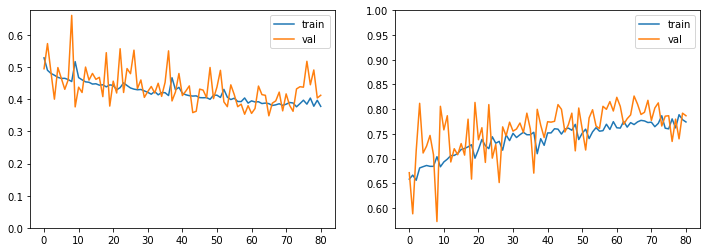

In [8]:
y = np.array([mrk.photo_reqs.blurred.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'blurred')
list_model_files.append(model_file)

#### 3. Looking Away

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6707 - accuracy: 0.5896 - precision: 0.7615 - recall: 0.5709 - f1: 0.6303 - specificity: 0.6121 - negative_predictive_value: 0.4164 - matthews_correlation_coefficient: 0.1814 - val_loss: 0.7225 - val_accuracy: 0.5403 - val_precision: 0.8046 - val_recall: 0.4468 - val_f1: 0.5659 - val_specificity: 0.7545 - val_negative_predictive_value: 0.3775 - val_matthews_correlation_coefficient: 0.1907

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19067, saving model to ../models/autoencoders_requirements/looking_away_2020_03_19-22_47_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6680 - accuracy: 0.5928 - precision: 0.7729 - recall: 0.5738 - f1: 0.6419 - specificity: 0.6291 - negative_predictive_value: 0.4139 - matthews_correlation_coefficient: 0.2008 - val_loss: 0.6517 - val_accuracy: 0.6114 - val_precision


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32980
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6256 - accuracy: 0.6657 - precision: 0.8039 - recall: 0.6815 - f1: 0.7309 - specificity: 0.6244 - negative_predictive_value: 0.4760 - matthews_correlation_coefficient: 0.2930 - val_loss: 0.5680 - val_accuracy: 0.6990 - val_precision: 0.7847 - val_recall: 0.7841 - val_f1: 0.7822 - val_specificity: 0.5049 - val_negative_predictive_value: 0.5140 - val_matthews_correlation_coefficient: 0.2923

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32980
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6173 - accuracy: 0.6664 - precision: 0.8040 - recall: 0.6720 - f1: 0.7247 - specificity: 0.6564 - negative_predictive_value: 0.4854 - matthews_correlation_coefficient: 0.3090 - val_loss: 0.6592 - val_accuracy: 0.6219 - val_precision: 0.8418 - val_recall: 0.5702 - val_f1: 0.6723 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5911 - accuracy: 0.6946 - precision: 0.8180 - recall: 0.7026 - f1: 0.7506 - specificity: 0.6747 - negative_predictive_value: 0.5159 - matthews_correlation_coefficient: 0.3558 - val_loss: 0.6104 - val_accuracy: 0.6522 - val_precision: 0.8531 - val_recall: 0.6116 - val_f1: 0.7067 - val_specificity: 0.7354 - val_negative_predictive_value: 0.4547 - val_matthews_correlation_coefficient: 0.3259

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37850
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5901 - accuracy: 0.6803 - precision: 0.8213 - recall: 0.6812 - f1: 0.7392 - specificity: 0.6745 - negative_predictive_value: 0.4957 - matthews_correlation_coefficient: 0.3362 - val_loss: 0.5878 - val_accuracy: 0.6860 - val_precision: 0.8261 - val_recall: 0.6980 - val_f1: 0.7531 - val_specificity: 0.6526 - val_negative_predictive_value: 0.4853 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5695 - accuracy: 0.6980 - precision: 0.8257 - recall: 0.7118 - f1: 0.7586 - specificity: 0.6640 - negative_predictive_value: 0.5204 - matthews_correlation_coefficient: 0.3613 - val_loss: 0.5412 - val_accuracy: 0.7268 - val_precision: 0.8421 - val_recall: 0.7503 - val_f1: 0.7909 - val_specificity: 0.6612 - val_negative_predictive_value: 0.5351 - val_matthews_correlation_coefficient: 0.3931

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.42258
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5741 - accuracy: 0.7046 - precision: 0.8359 - recall: 0.7195 - f1: 0.7642 - specificity: 0.6861 - negative_predictive_value: 0.5396 - matthews_correlation_coefficient: 0.3887 - val_loss: 0.5740 - val_accuracy: 0.6826 - val_precision: 0.8384 - val_recall: 0.6765 - val_f1: 0.7449 - val_specificity: 0.6859 - val_negative_predictive_value: 0.4808 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5606 - accuracy: 0.7102 - precision: 0.8333 - recall: 0.7311 - f1: 0.7728 - specificity: 0.6723 - negative_predictive_value: 0.5372 - matthews_correlation_coefficient: 0.3852 - val_loss: 0.5445 - val_accuracy: 0.7164 - val_precision: 0.8591 - val_recall: 0.7128 - val_f1: 0.7758 - val_specificity: 0.7096 - val_negative_predictive_value: 0.5152 - val_matthews_correlation_coefficient: 0.3968

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.42258
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5529 - accuracy: 0.7041 - precision: 0.8420 - recall: 0.7017 - f1: 0.7587 - specificity: 0.7042 - negative_predictive_value: 0.5229 - matthews_correlation_coefficient: 0.3854 - val_loss: 0.6399 - val_accuracy: 0.6479 - val_precision: 0.8785 - val_recall: 0.5787 - val_f1: 0.6928 - val_specificity: 0.7988 - val_negative_predictive_value: 0.4515 - val_matthews_correlation_coefficie

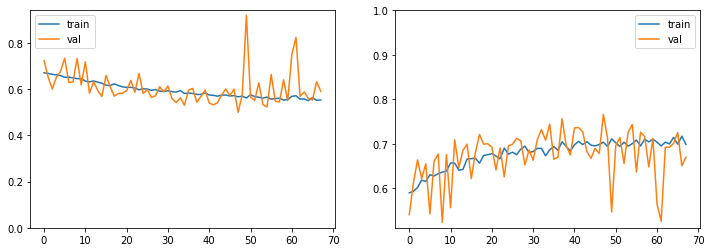

In [9]:
y = np.array([mrk.photo_reqs.looking_away.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'looking_away')
list_model_files.append(model_file)

#### 4. Ink Marked/Creased

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.7725 - accuracy: 0.4410 - precision: 0.8415 - recall: 0.4449 - f1: 0.5170 - specificity: 0.0483 - negative_predictive_value: 0.0027 - matthews_correlation_coefficient: -0.0061 - val_loss: 0.2692 - val_accuracy: 0.9965 - val_precision: 0.9966 - val_recall: 1.0000 - val_f1: 0.9983 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/ink_marked_creased_2020_03_19-22_57_13.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.8610 - accuracy: 0.3805 - precision: 0.6933 - recall: 0.3785 - f1: 0.4348 - specificity: 0.0483 - negative_predictive_value: 0.0021 - matthews_correlation_coefficient: -0.0018 - val_loss: 0.7803 - val_accuracy: 0.

4610/4610 [==============================] - 9s 2ms/step - loss: 0.7134 - accuracy: 0.7013 - precision: 0.9897 - recall: 0.6980 - f1: 0.7939 - specificity: 0.0379 - negative_predictive_value: 0.0028 - matthews_correlation_coefficient: 0.0013 - val_loss: 0.8215 - val_accuracy: 0.2376 - val_precision: 0.9970 - val_recall: 0.2559 - val_f1: 0.3921 - val_specificity: 0.0811 - val_negative_predictive_value: 0.0033 - val_matthews_correlation_coefficient: 4.1099e-04

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6860 - accuracy: 0.5738 - precision: 0.9909 - recall: 0.5701 - f1: 0.7082 - specificity: 0.0690 - negative_predictive_value: 0.0052 - matthews_correlation_coefficient: 0.0082 - val_loss: 0.7474 - val_accuracy: 0.4224 - val_precision: 0.9961 - val_recall: 0.4374 - val_f1: 0.5983 - val_specificity: 0.0541 - val_negative_predictive_value: 0.0034 - val_matthews_correlation_coeff


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6708 - accuracy: 0.4393 - precision: 0.9974 - recall: 0.4390 - f1: 0.6055 - specificity: 0.0690 - negative_predictive_value: 0.0044 - matthews_correlation_coefficient: 0.0043 - val_loss: 0.7171 - val_accuracy: 0.4406 - val_precision: 0.9950 - val_recall: 0.4560 - val_f1: 0.6167 - val_specificity: 0.0270 - val_negative_predictive_value: 0.0015 - val_matthews_correlation_coefficient: -0.0101

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.01015
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6874 - accuracy: 0.3959 - precision: 0.9978 - recall: 0.3955 - f1: 0.5528 - specificity: 0.0793 - negative_predictive_value: 0.0043 - matthews_correlation_coefficient: 0.0053 - val_loss: 0.7007 - val_accuracy: 0.4354 - val_precision: 0.9950 - val_recall: 0.4510 - val_f1: 0.6121 - val_sp

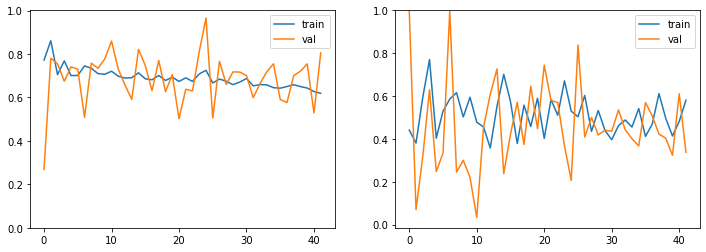

In [10]:
y = np.array([mrk.photo_reqs.ink_marked_creased.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'ink_marked_creased')
list_model_files.append(model_file)

#### 5. Unnatural Skin Tone 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6581 - accuracy: 0.6091 - precision: 0.6094 - recall: 0.5875 - f1: 0.5616 - specificity: 0.6154 - negative_predictive_value: 0.6233 - matthews_correlation_coefficient: 0.2195 - val_loss: 0.6315 - val_accuracy: 0.6193 - val_precision: 0.6026 - val_recall: 0.5465 - val_f1: 0.5654 - val_specificity: 0.6776 - val_negative_predictive_value: 0.6195 - val_matthews_correlation_coefficient: 0.2229

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.22291, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_19-23_03_30.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6276 - accuracy: 0.6505 - precision: 0.6384 - recall: 0.6964 - f1: 0.6461 - specificity: 0.6126 - negative_predictive_value: 0.6927 - matthews_correlation_coefficient: 0.3207 - val_loss: 0.6367 - val_accuracy: 0.6323 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5441 - accuracy: 0.7104 - precision: 0.6824 - recall: 0.7829 - f1: 0.7196 - specificity: 0.6385 - negative_predictive_value: 0.7566 - matthews_correlation_coefficient: 0.4314 - val_loss: 0.5781 - val_accuracy: 0.6973 - val_precision: 0.6554 - val_recall: 0.7080 - val_f1: 0.6725 - val_specificity: 0.6706 - val_negative_predictive_value: 0.7209 - val_matthews_correlation_coefficient: 0.3771

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.38148
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5423 - accuracy: 0.7106 - precision: 0.6874 - recall: 0.7796 - f1: 0.7187 - specificity: 0.6459 - negative_predictive_value: 0.7526 - matthews_correlation_coefficient: 0.4339 - val_loss: 0.5768 - val_accuracy: 0.6947 - val_precision: 0.6430 - val_recall: 0.7516 - val_f1: 0.6833 - val_specificity: 0.6287 - val_negative_predictive_value: 0.7403 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5220 - accuracy: 0.7330 - precision: 0.7015 - recall: 0.8078 - f1: 0.7422 - specificity: 0.6666 - negative_predictive_value: 0.7750 - matthews_correlation_coefficient: 0.4768 - val_loss: 0.5902 - val_accuracy: 0.6479 - val_precision: 0.5961 - val_recall: 0.7176 - val_f1: 0.6433 - val_specificity: 0.5702 - val_negative_predictive_value: 0.6931 - val_matthews_correlation_coefficient: 0.2881

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40214
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5203 - accuracy: 0.7332 - precision: 0.7126 - recall: 0.7815 - f1: 0.7352 - specificity: 0.6970 - negative_predictive_value: 0.7743 - matthews_correlation_coefficient: 0.4822 - val_loss: 0.5837 - val_accuracy: 0.6704 - val_precision: 0.6209 - val_recall: 0.7378 - val_f1: 0.6646 - val_specificity: 0.6027 - val_negative_predictive_value: 0.7206 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4992 - accuracy: 0.7534 - precision: 0.7227 - recall: 0.7898 - f1: 0.7463 - specificity: 0.7093 - negative_predictive_value: 0.7843 - matthews_correlation_coefficient: 0.5095 - val_loss: 0.5822 - val_accuracy: 0.6912 - val_precision: 0.6955 - val_recall: 0.5795 - val_f1: 0.6258 - val_specificity: 0.7805 - val_negative_predictive_value: 0.6720 - val_matthews_correlation_coefficient: 0.3635

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41748
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5026 - accuracy: 0.7436 - precision: 0.7168 - recall: 0.7797 - f1: 0.7382 - specificity: 0.7016 - negative_predictive_value: 0.7715 - matthews_correlation_coefficient: 0.4914 - val_loss: 0.5859 - val_accuracy: 0.6713 - val_precision: 0.6602 - val_recall: 0.6144 - val_f1: 0.6300 - val_specificity: 0.7092 - val_negative_predictive_value: 0.6640 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41758
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4854 - accuracy: 0.7542 - precision: 0.7217 - recall: 0.7969 - f1: 0.7506 - specificity: 0.7099 - negative_predictive_value: 0.7906 - matthews_correlation_coefficient: 0.5109 - val_loss: 0.5588 - val_accuracy: 0.6912 - val_precision: 0.6603 - val_recall: 0.6885 - val_f1: 0.6663 - val_specificity: 0.6832 - val_negative_predictive_value: 0.7056 - val_matthews_correlation_coefficient: 0.3686

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41758
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4938 - accuracy: 0.7547 - precision: 0.7317 - recall: 0.7990 - f1: 0.7559 - specificity: 0.7166 - negative_predictive_value: 0.7938 - matthews_correlation_coefficient: 0.5201 - val_loss: 0.5597 - val_accuracy: 0.7051 - val_precision: 0.6393 - val_recall: 0.8160 - val_f1: 0.7085 - val_spe


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.42049
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4854 - accuracy: 0.7620 - precision: 0.7360 - recall: 0.8174 - f1: 0.7663 - specificity: 0.7143 - negative_predictive_value: 0.8072 - matthews_correlation_coefficient: 0.5371 - val_loss: 0.5582 - val_accuracy: 0.7181 - val_precision: 0.6702 - val_recall: 0.7602 - val_f1: 0.7045 - val_specificity: 0.6659 - val_negative_predictive_value: 0.7570 - val_matthews_correlation_coefficient: 0.4261

Epoch 00073: val_matthews_correlation_coefficient improved from 0.42049 to 0.42608, saving model to ../models/autoencoders_requirements/unnatural_skin_tone_2020_03_19-23_03_30.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4834 - accuracy: 0.7623 - precision: 0.7347 - recall: 0.8149 - f1: 0.7644 - specificity: 0.7193 - negative_predictive_value: 0.8094 - matthews_correlation_coefficient: 0.5388 - val_loss: 0

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4725 - accuracy: 0.7692 - precision: 0.7418 - recall: 0.8235 - f1: 0.7742 - specificity: 0.7228 - negative_predictive_value: 0.8119 - matthews_correlation_coefficient: 0.5495 - val_loss: 0.5608 - val_accuracy: 0.6999 - val_precision: 0.6657 - val_recall: 0.7090 - val_f1: 0.6782 - val_specificity: 0.6859 - val_negative_predictive_value: 0.7197 - val_matthews_correlation_coefficient: 0.3898

Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.43168
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4773 - accuracy: 0.7638 - precision: 0.7292 - recall: 0.8094 - f1: 0.7599 - specificity: 0.7191 - negative_predictive_value: 0.8027 - matthews_correlation_coefficient: 0.5315 - val_loss: 0.5584 - val_accuracy: 0.7129 - val_precision: 0.6972 - val_recall: 0.6734 - val_f1: 0.6750 - val_specificity: 0.7387 - val_negative_predictive_value: 0.7150 - val_matthews_correlation_coefficie

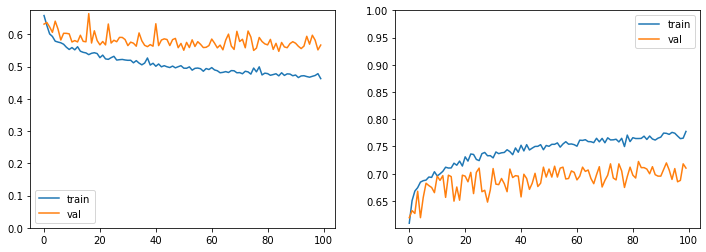

In [11]:
y = np.array([mrk.photo_reqs.unnatural_skin_tone.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'unnatural_skin_tone')
list_model_files.append(model_file)

#### 6. Too Dark/Light 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6170 - accuracy: 0.6360 - precision: 0.9608 - recall: 0.6369 - f1: 0.7361 - specificity: 0.5689 - negative_predictive_value: 0.1402 - matthews_correlation_coefficient: 0.1529 - val_loss: 0.7879 - val_accuracy: 0.4276 - val_precision: 0.9707 - val_recall: 0.3698 - val_f1: 0.5312 - val_specificity: 0.9369 - val_negative_predictive_value: 0.1407 - val_matthews_correlation_coefficient: 0.1859

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18589, saving model to ../models/autoencoders_requirements/too_dark_light_2020_03_19-23_18_15.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5322 - accuracy: 0.6963 - precision: 0.9740 - recall: 0.6959 - f1: 0.7954 - specificity: 0.7304 - negative_predictive_value: 0.1978 - matthews_correlation_coefficient: 0.2641 - val_loss: 0.5909 - val_accuracy: 0.7164 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4318 - accuracy: 0.8141 - precision: 0.9734 - recall: 0.8227 - f1: 0.8881 - specificity: 0.6994 - negative_predictive_value: 0.2902 - matthews_correlation_coefficient: 0.3624 - val_loss: 0.4373 - val_accuracy: 0.8213 - val_precision: 0.9548 - val_recall: 0.8003 - val_f1: 0.8688 - val_specificity: 0.7894 - val_negative_predictive_value: 0.2960 - val_matthews_correlation_coefficient: 0.3750

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.44999
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4271 - accuracy: 0.8260 - precision: 0.9789 - recall: 0.8318 - f1: 0.8957 - specificity: 0.7216 - negative_predictive_value: 0.2997 - matthews_correlation_coefficient: 0.3831 - val_loss: 0.4460 - val_accuracy: 0.8179 - val_precision: 0.9568 - val_recall: 0.7946 - val_f1: 0.8661 - val_specificity: 0.8051 - val_negative_predictive_value: 0.2964 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.46052
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3837 - accuracy: 0.8434 - precision: 0.9793 - recall: 0.8467 - f1: 0.9054 - specificity: 0.7383 - negative_predictive_value: 0.3292 - matthews_correlation_coefficient: 0.4159 - val_loss: 0.3881 - val_accuracy: 0.8465 - val_precision: 0.9584 - val_recall: 0.8243 - val_f1: 0.8850 - val_specificity: 0.8142 - val_negative_predictive_value: 0.3304 - val_matthews_correlation_coefficient: 0.4173

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.46052
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3773 - accuracy: 0.8436 - precision: 0.9798 - recall: 0.8498 - f1: 0.9079 - specificity: 0.7269 - negative_predictive_value: 0.3255 - matthews_correlation_coefficient: 0.4116 - val_loss: 0.4164 - val_accuracy: 0.8109 - val_precision: 0.9623 - val_recall: 0.7834 - val_f1: 0.8619 - val_spe


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.46052
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3701 - accuracy: 0.8458 - precision: 0.9822 - recall: 0.8501 - f1: 0.9086 - specificity: 0.7789 - negative_predictive_value: 0.3399 - matthews_correlation_coefficient: 0.4395 - val_loss: 0.4117 - val_accuracy: 0.8317 - val_precision: 0.9604 - val_recall: 0.8072 - val_f1: 0.8757 - val_specificity: 0.8367 - val_negative_predictive_value: 0.3168 - val_matthews_correlation_coefficient: 0.4102

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46052
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3586 - accuracy: 0.8553 - precision: 0.9810 - recall: 0.8622 - f1: 0.9156 - specificity: 0.7238 - negative_predictive_value: 0.3405 - matthews_correlation_coefficient: 0.4247 - val_loss: 0.5702 - val_accuracy: 0.7355 - val_precision: 0.9672 - val_recall: 0.6993 - val_f1: 0.8094 - val_spe

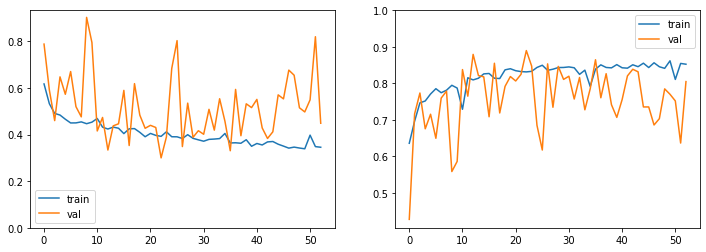

In [12]:
y = np.array([mrk.photo_reqs.too_dark_light.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'too_dark_light')
list_model_files.append(model_file)

#### 7. Washed Out

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5820 - accuracy: 0.8221 - precision: 0.9966 - recall: 0.8225 - f1: 0.8938 - specificity: 0.0931 - negative_predictive_value: 0.0271 - matthews_correlation_coefficient: 0.0391 - val_loss: 0.4313 - val_accuracy: 0.7086 - val_precision: 1.0000 - val_recall: 0.7145 - val_f1: 0.8311 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0192 - val_matthews_correlation_coefficient: 0.0505

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.05055, saving model to ../models/autoencoders_requirements/washed_out_2020_03_19-23_26_14.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4133 - accuracy: 0.7642 - precision: 0.9988 - recall: 0.7655 - f1: 0.8594 - specificity: 0.1621 - negative_predictive_value: 0.0338 - matthews_correlation_coefficient: 0.0603 - val_loss: 0.0846 - val_accuracy: 0.9853 - val_precision: 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2011 - accuracy: 0.9087 - precision: 0.9995 - recall: 0.9060 - f1: 0.9469 - specificity: 0.1793 - negative_predictive_value: 0.0979 - matthews_correlation_coefficient: 0.1224 - val_loss: 0.1712 - val_accuracy: 0.9159 - val_precision: 1.0000 - val_recall: 0.9176 - val_f1: 0.9563 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0730 - val_matthews_correlation_coefficient: 0.1085

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.15628
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1567 - accuracy: 0.9267 - precision: 0.9996 - recall: 0.9271 - f1: 0.9600 - specificity: 0.1862 - negative_predictive_value: 0.0859 - matthews_correlation_coefficient: 0.1163 - val_loss: 0.2020 - val_accuracy: 0.9193 - val_precision: 1.0000 - val_recall: 0.9211 - val_f1: 0.9583 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0653 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1343 - accuracy: 0.9321 - precision: 0.9998 - recall: 0.9321 - f1: 0.9631 - specificity: 0.1931 - negative_predictive_value: 0.0880 - matthews_correlation_coefficient: 0.1179 - val_loss: 0.2510 - val_accuracy: 0.8760 - val_precision: 1.0000 - val_recall: 0.8784 - val_f1: 0.9345 - val_specificity: 0.1892 - val_negative_predictive_value: 0.0394 - val_matthews_correlation_coefficient: 0.0799

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.15628
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1185 - accuracy: 0.9362 - precision: 0.9998 - recall: 0.9333 - f1: 0.9629 - specificity: 0.1828 - negative_predictive_value: 0.1126 - matthews_correlation_coefficient: 0.1340 - val_loss: 0.0968 - val_accuracy: 0.9601 - val_precision: 1.0000 - val_recall: 0.9609 - val_f1: 0.9798 - val_specificity: 0.1892 - val_negative_predictive_value: 0.1036 - val_matthews_correlation_coefficie

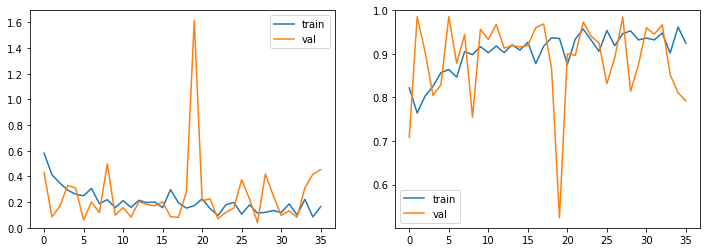

In [13]:
y = np.array([mrk.photo_reqs.washed_out.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'washed_out')
list_model_files.append(model_file)

#### 8. Pixelation

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6615 - accuracy: 0.5868 - precision: 0.9472 - recall: 0.5815 - f1: 0.7038 - specificity: 0.6060 - negative_predictive_value: 0.1066 - matthews_correlation_coefficient: 0.1237 - val_loss: 0.7305 - val_accuracy: 0.4840 - val_precision: 0.9451 - val_recall: 0.4486 - val_f1: 0.6027 - val_specificity: 0.6635 - val_negative_predictive_value: 0.0980 - val_matthews_correlation_coefficient: 0.1145

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.11453, saving model to ../models/autoencoders_requirements/pixelation_2020_03_19-23_31_40.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6396 - accuracy: 0.6193 - precision: 0.9683 - recall: 0.6114 - f1: 0.7371 - specificity: 0.6097 - negative_predictive_value: 0.1194 - matthews_correlation_coefficient: 0.1505 - val_loss: 0.6133 - val_accuracy: 0.5716 - val_precision: 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5428 - accuracy: 0.6829 - precision: 0.9772 - recall: 0.6752 - f1: 0.7931 - specificity: 0.7222 - negative_predictive_value: 0.1569 - matthews_correlation_coefficient: 0.2342 - val_loss: 0.3400 - val_accuracy: 0.8317 - val_precision: 0.9541 - val_recall: 0.8666 - val_f1: 0.9065 - val_specificity: 0.3099 - val_negative_predictive_value: 0.1758 - val_matthews_correlation_coefficient: 0.1538

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5405 - accuracy: 0.6987 - precision: 0.9746 - recall: 0.6963 - f1: 0.8077 - specificity: 0.7093 - negative_predictive_value: 0.1557 - matthews_correlation_coefficient: 0.2312 - val_loss: 0.3810 - val_accuracy: 0.7676 - val_precision: 0.9675 - val_recall: 0.7837 - val_f1: 0.8636 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5241 - accuracy: 0.7061 - precision: 0.9706 - recall: 0.6958 - f1: 0.8053 - specificity: 0.6967 - negative_predictive_value: 0.1655 - matthews_correlation_coefficient: 0.2350 - val_loss: 0.5409 - val_accuracy: 0.6791 - val_precision: 0.9762 - val_recall: 0.6807 - val_f1: 0.7984 - val_specificity: 0.6050 - val_negative_predictive_value: 0.1419 - val_matthews_correlation_coefficient: 0.1900

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.22597
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5856 - accuracy: 0.6382 - precision: 0.9733 - recall: 0.6329 - f1: 0.7496 - specificity: 0.6896 - negative_predictive_value: 0.1521 - matthews_correlation_coefficient: 0.2058 - val_loss: 0.3293 - val_accuracy: 0.8864 - val_precision: 0.9532 - val_recall: 0.9269 - val_f1: 0.9388 - val_spe

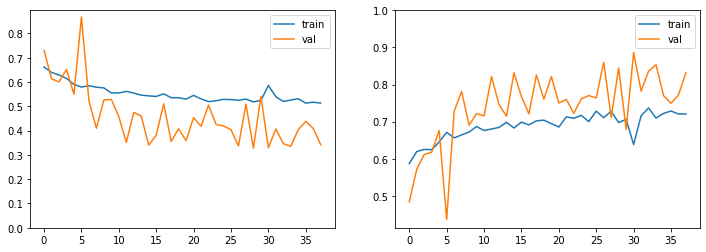

In [14]:
y = np.array([mrk.photo_reqs.pixelation.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'pixelation')
list_model_files.append(model_file)

#### 9. Hair Across Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5634 - accuracy: 0.6573 - precision: 0.9749 - recall: 0.6436 - f1: 0.7655 - specificity: 0.7970 - negative_predictive_value: 0.2057 - matthews_correlation_coefficient: 0.2773 - val_loss: 0.6016 - val_accuracy: 0.6288 - val_precision: 0.9921 - val_recall: 0.6051 - val_f1: 0.7471 - val_specificity: 0.8527 - val_negative_predictive_value: 0.1873 - val_matthews_correlation_coefficient: 0.2912

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.29121, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_19-23_37_23.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5291 - accuracy: 0.6427 - precision: 0.9839 - recall: 0.6184 - f1: 0.7561 - specificity: 0.8545 - negative_predictive_value: 0.1951 - matthews_correlation_coefficient: 0.2898 - val_loss: 0.5110 - val_accuracy: 0.6409 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4291 - accuracy: 0.7961 - precision: 0.9821 - recall: 0.7925 - f1: 0.8723 - specificity: 0.8088 - negative_predictive_value: 0.3145 - matthews_correlation_coefficient: 0.4153 - val_loss: 0.2550 - val_accuracy: 0.8890 - val_precision: 0.9607 - val_recall: 0.9194 - val_f1: 0.9383 - val_specificity: 0.5432 - val_negative_predictive_value: 0.4333 - val_matthews_correlation_coefficient: 0.4193

Epoch 00015: val_matthews_correlation_coefficient improved from 0.41863 to 0.41934, saving model to ../models/autoencoders_requirements/hair_across_eyes_2020_03_19-23_37_23.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4267 - accuracy: 0.8004 - precision: 0.9827 - recall: 0.7957 - f1: 0.8752 - specificity: 0.8189 - negative_predictive_value: 0.3117 - matthews_correlation_coefficient: 0.4158 - val_loss: 0.3866 - val_accuracy: 0.8239 - val_precision: 0.9780 - val_recall: 0.8298 - val_f1: 0.8964 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4006 - accuracy: 0.8230 - precision: 0.9814 - recall: 0.8225 - f1: 0.8924 - specificity: 0.8292 - negative_predictive_value: 0.3329 - matthews_correlation_coefficient: 0.4417 - val_loss: 0.3839 - val_accuracy: 0.8257 - val_precision: 0.9867 - val_recall: 0.8241 - val_f1: 0.8964 - val_specificity: 0.7865 - val_negative_predictive_value: 0.3251 - val_matthews_correlation_coefficient: 0.4347

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.46034
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4075 - accuracy: 0.8258 - precision: 0.9811 - recall: 0.8236 - f1: 0.8924 - specificity: 0.8247 - negative_predictive_value: 0.3436 - matthews_correlation_coefficient: 0.4525 - val_loss: 0.5634 - val_accuracy: 0.7650 - val_precision: 0.9881 - val_recall: 0.7569 - val_f1: 0.8544 - val_specificity: 0.8023 - val_negative_predictive_value: 0.2664 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3884 - accuracy: 0.8258 - precision: 0.9842 - recall: 0.8193 - f1: 0.8919 - specificity: 0.7752 - negative_predictive_value: 0.3324 - matthews_correlation_coefficient: 0.4322 - val_loss: 0.4076 - val_accuracy: 0.8300 - val_precision: 0.9880 - val_recall: 0.8277 - val_f1: 0.8990 - val_specificity: 0.7932 - val_negative_predictive_value: 0.3302 - val_matthews_correlation_coefficient: 0.4431

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.46034
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3815 - accuracy: 0.8332 - precision: 0.9843 - recall: 0.8304 - f1: 0.8986 - specificity: 0.8086 - negative_predictive_value: 0.3468 - matthews_correlation_coefficient: 0.4541 - val_loss: 0.3777 - val_accuracy: 0.8448 - val_precision: 0.9882 - val_recall: 0.8439 - val_f1: 0.9087 - val_specificity: 0.7932 - val_negative_predictive_value: 0.3551 - val_matthews_correlation_coefficie


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.46536
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3647 - accuracy: 0.8440 - precision: 0.9864 - recall: 0.8410 - f1: 0.9061 - specificity: 0.8161 - negative_predictive_value: 0.3701 - matthews_correlation_coefficient: 0.4787 - val_loss: 0.3568 - val_accuracy: 0.8491 - val_precision: 0.9827 - val_recall: 0.8529 - val_f1: 0.9120 - val_specificity: 0.7527 - val_negative_predictive_value: 0.3525 - val_matthews_correlation_coefficient: 0.4493

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.46536
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3649 - accuracy: 0.8375 - precision: 0.9866 - recall: 0.8304 - f1: 0.8991 - specificity: 0.8431 - negative_predictive_value: 0.3586 - matthews_correlation_coefficient: 0.4745 - val_loss: 0.3631 - val_accuracy: 0.8465 - val_precision: 0.9819 - val_recall: 0.8511 - val_f1: 0.9106 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.46536
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3555 - accuracy: 0.8430 - precision: 0.9857 - recall: 0.8369 - f1: 0.9029 - specificity: 0.8132 - negative_predictive_value: 0.3595 - matthews_correlation_coefficient: 0.4690 - val_loss: 0.2828 - val_accuracy: 0.8699 - val_precision: 0.9806 - val_recall: 0.8786 - val_f1: 0.9255 - val_specificity: 0.7032 - val_negative_predictive_value: 0.3917 - val_matthews_correlation_coefficient: 0.4636

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.46536
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3581 - accuracy: 0.8427 - precision: 0.9855 - recall: 0.8373 - f1: 0.9029 - specificity: 0.8496 - negative_predictive_value: 0.3641 - matthews_correlation_coefficient: 0.4798 - val_loss: 0.4174 - val_accuracy: 0.8274 - val_precision: 0.9909 - val_recall: 0.8219 - val_f1: 0.8966 - val_spe

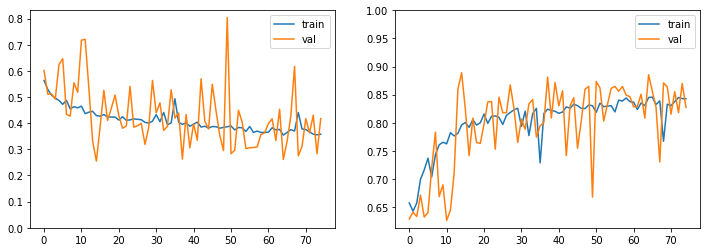

In [15]:
y = np.array([mrk.photo_reqs.hair_across_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hair_across_eyes')
list_model_files.append(model_file)

#### 10. Eyes Closed  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6322 - accuracy: 0.5317 - precision: 0.9179 - recall: 0.4591 - f1: 0.6020 - specificity: 0.8210 - negative_predictive_value: 0.2750 - matthews_correlation_coefficient: 0.2309 - val_loss: 0.6513 - val_accuracy: 0.4848 - val_precision: 0.9032 - val_recall: 0.3769 - val_f1: 0.5244 - val_specificity: 0.8788 - val_negative_predictive_value: 0.2839 - val_matthews_correlation_coefficient: 0.2158

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.21584, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_19-23_48_44.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6239 - accuracy: 0.5278 - precision: 0.9259 - recall: 0.4497 - f1: 0.5960 - specificity: 0.8371 - negative_predictive_value: 0.2772 - matthews_correlation_coefficient: 0.2405 - val_loss: 0.6248 - val_accuracy: 0.5421 - val_precision:

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5731 - accuracy: 0.6490 - precision: 0.9182 - recall: 0.6199 - f1: 0.7310 - specificity: 0.7706 - negative_predictive_value: 0.3446 - matthews_correlation_coefficient: 0.3179 - val_loss: 0.6218 - val_accuracy: 0.5984 - val_precision: 0.9060 - val_recall: 0.5242 - val_f1: 0.6591 - val_specificity: 0.8363 - val_negative_predictive_value: 0.3297 - val_matthews_correlation_coefficient: 0.2892

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.30451
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5724 - accuracy: 0.6419 - precision: 0.9204 - recall: 0.6014 - f1: 0.7179 - specificity: 0.7989 - negative_predictive_value: 0.3418 - matthews_correlation_coefficient: 0.3277 - val_loss: 0.6806 - val_accuracy: 0.5386 - val_precision: 0.8988 - val_recall: 0.4494 - val_f1: 0.5930 - val_specificity: 0.8508 - val_negative_predictive_value: 0.3051 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5382 - accuracy: 0.6683 - precision: 0.9226 - recall: 0.6403 - f1: 0.7488 - specificity: 0.7713 - negative_predictive_value: 0.3548 - matthews_correlation_coefficient: 0.3374 - val_loss: 0.4941 - val_accuracy: 0.7155 - val_precision: 0.8709 - val_recall: 0.7094 - val_f1: 0.7796 - val_specificity: 0.6751 - val_negative_predictive_value: 0.3925 - val_matthews_correlation_coefficient: 0.3163

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.33348
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5418 - accuracy: 0.6766 - precision: 0.9218 - recall: 0.6532 - f1: 0.7567 - specificity: 0.7520 - negative_predictive_value: 0.3598 - matthews_correlation_coefficient: 0.3365 - val_loss: 0.6558 - val_accuracy: 0.5889 - val_precision: 0.9094 - val_recall: 0.5099 - val_f1: 0.6478 - val_specificity: 0.8493 - val_negative_predictive_value: 0.3281 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.33435
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5222 - accuracy: 0.6935 - precision: 0.9291 - recall: 0.6700 - f1: 0.7715 - specificity: 0.7744 - negative_predictive_value: 0.3759 - matthews_correlation_coefficient: 0.3667 - val_loss: 0.4438 - val_accuracy: 0.7702 - val_precision: 0.8565 - val_recall: 0.8019 - val_f1: 0.8260 - val_specificity: 0.5716 - val_negative_predictive_value: 0.4511 - val_matthews_correlation_coefficient: 0.3364

Epoch 00044: val_matthews_correlation_coefficient improved from 0.33435 to 0.33644, saving model to ../models/autoencoders_requirements/eyes_closed_2020_03_19-23_48_44.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5261 - accuracy: 0.6913 - precision: 0.9248 - recall: 0.6749 - f1: 0.7739 - specificity: 0.7807 - negative_predictive_value: 0.3810 - matthews_correlation_coefficient: 0.3689 - val_loss: 0.5632 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5105 - accuracy: 0.7132 - precision: 0.9350 - recall: 0.6951 - f1: 0.7906 - specificity: 0.7908 - negative_predictive_value: 0.3991 - matthews_correlation_coefficient: 0.3988 - val_loss: 0.6558 - val_accuracy: 0.6123 - val_precision: 0.9038 - val_recall: 0.5448 - val_f1: 0.6745 - val_specificity: 0.8299 - val_negative_predictive_value: 0.3385 - val_matthews_correlation_coefficient: 0.2991

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.35854
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5102 - accuracy: 0.6961 - precision: 0.9291 - recall: 0.6717 - f1: 0.7735 - specificity: 0.7919 - negative_predictive_value: 0.3837 - matthews_correlation_coefficient: 0.3787 - val_loss: 0.5002 - val_accuracy: 0.7311 - val_precision: 0.8690 - val_recall: 0.7338 - val_f1: 0.7929 - val_specificity: 0.6622 - val_negative_predictive_value: 0.4151 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.36014
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5008 - accuracy: 0.7158 - precision: 0.9318 - recall: 0.6988 - f1: 0.7922 - specificity: 0.7967 - negative_predictive_value: 0.4028 - matthews_correlation_coefficient: 0.4026 - val_loss: 0.5769 - val_accuracy: 0.6305 - val_precision: 0.9091 - val_recall: 0.5627 - val_f1: 0.6920 - val_specificity: 0.8410 - val_negative_predictive_value: 0.3508 - val_matthews_correlation_coefficient: 0.3216

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.36014
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4898 - accuracy: 0.7208 - precision: 0.9329 - recall: 0.7048 - f1: 0.7974 - specificity: 0.7855 - negative_predictive_value: 0.4068 - matthews_correlation_coefficient: 0.4038 - val_loss: 0.8188 - val_accuracy: 0.5386 - val_precision: 0.9116 - val_recall: 0.4414 - val_f1: 0.5892 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.36052
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4811 - accuracy: 0.7176 - precision: 0.9359 - recall: 0.6983 - f1: 0.7938 - specificity: 0.7930 - negative_predictive_value: 0.4063 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.6712 - val_accuracy: 0.6227 - val_precision: 0.9073 - val_recall: 0.5577 - val_f1: 0.6853 - val_specificity: 0.8336 - val_negative_predictive_value: 0.3479 - val_matthews_correlation_coefficient: 0.3134

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.36052
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7275 - precision: 0.9288 - recall: 0.7062 - f1: 0.7970 - specificity: 0.7970 - negative_predictive_value: 0.4201 - matthews_correlation_coefficient: 0.4162 - val_loss: 0.7969 - val_accuracy: 0.5611 - val_precision: 0.9318 - val_recall: 0.4624 - val_f1: 0.6110 - val_spe

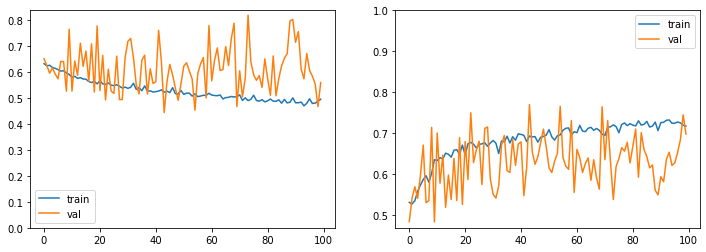

In [16]:
y = np.array([mrk.photo_reqs.eyes_closed.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'eyes_closed')
list_model_files.append(model_file)

#### 11. Varied Background

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5119 - accuracy: 0.7315 - precision: 0.8068 - recall: 0.7023 - f1: 0.7205 - specificity: 0.7694 - negative_predictive_value: 0.7102 - matthews_correlation_coefficient: 0.4907 - val_loss: 0.5821 - val_accuracy: 0.6696 - val_precision: 0.8919 - val_recall: 0.4479 - val_f1: 0.5876 - val_specificity: 0.9197 - val_negative_predictive_value: 0.5590 - val_matthews_correlation_coefficient: 0.4325

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.43247, saving model to ../models/autoencoders_requirements/varied_background_2020_03_20-00_03_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4449 - accuracy: 0.7692 - precision: 0.8317 - recall: 0.7626 - f1: 0.7803 - specificity: 0.7890 - negative_predictive_value: 0.7294 - matthews_correlation_coefficient: 0.5570 - val_loss: 0.4122 - val_accuracy: 0.7780 - val_prec

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3740 - accuracy: 0.8132 - precision: 0.8680 - recall: 0.8054 - f1: 0.8241 - specificity: 0.8360 - negative_predictive_value: 0.7789 - matthews_correlation_coefficient: 0.6434 - val_loss: 0.3673 - val_accuracy: 0.8109 - val_precision: 0.7985 - val_recall: 0.8312 - val_f1: 0.8112 - val_specificity: 0.7352 - val_negative_predictive_value: 0.7723 - val_matthews_correlation_coefficient: 0.5952

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.61707
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3631 - accuracy: 0.8226 - precision: 0.8714 - recall: 0.8174 - f1: 0.8356 - specificity: 0.8432 - negative_predictive_value: 0.7814 - matthews_correlation_coefficient: 0.6563 - val_loss: 0.3669 - val_accuracy: 0.8196 - val_precision: 0.8509 - val_recall: 0.7759 - val_f1: 0.8086 - val_specificity: 0.8225 - val_negative_predictive_value: 0.7380 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3338 - accuracy: 0.8438 - precision: 0.8939 - recall: 0.8251 - f1: 0.8513 - specificity: 0.8674 - negative_predictive_value: 0.7927 - matthews_correlation_coefficient: 0.6908 - val_loss: 0.3635 - val_accuracy: 0.8083 - val_precision: 0.7863 - val_recall: 0.8402 - val_f1: 0.8098 - val_specificity: 0.7100 - val_negative_predictive_value: 0.7820 - val_matthews_correlation_coefficient: 0.5858

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.64180
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3255 - accuracy: 0.8434 - precision: 0.8780 - recall: 0.8319 - f1: 0.8495 - specificity: 0.8523 - negative_predictive_value: 0.8063 - matthews_correlation_coefficient: 0.6857 - val_loss: 0.3754 - val_accuracy: 0.8075 - val_precision: 0.8771 - val_recall: 0.7252 - val_f1: 0.7916 - val_specificity: 0.8613 - val_negative_predictive_value: 0.7009 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3183 - accuracy: 0.8460 - precision: 0.8966 - recall: 0.8287 - f1: 0.8553 - specificity: 0.8762 - negative_predictive_value: 0.8015 - matthews_correlation_coefficient: 0.7010 - val_loss: 0.3366 - val_accuracy: 0.8335 - val_precision: 0.8621 - val_recall: 0.7891 - val_f1: 0.8213 - val_specificity: 0.8383 - val_negative_predictive_value: 0.7544 - val_matthews_correlation_coefficient: 0.6486

Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.65903
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3131 - accuracy: 0.8469 - precision: 0.8880 - recall: 0.8282 - f1: 0.8509 - specificity: 0.8745 - negative_predictive_value: 0.8013 - matthews_correlation_coefficient: 0.6973 - val_loss: 0.3508 - val_accuracy: 0.8153 - val_precision: 0.8459 - val_recall: 0.7667 - val_f1: 0.8011 - val_specificity: 0.8268 - val_negative_predictive_value: 0.7364 - val_matthews_correlation_coefficie


Epoch 00056: val_matthews_correlation_coefficient did not improve from 0.66691
Epoch 57/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2940 - accuracy: 0.8560 - precision: 0.9003 - recall: 0.8289 - f1: 0.8589 - specificity: 0.8861 - negative_predictive_value: 0.8069 - matthews_correlation_coefficient: 0.7125 - val_loss: 0.3221 - val_accuracy: 0.8500 - val_precision: 0.8560 - val_recall: 0.8237 - val_f1: 0.8379 - val_specificity: 0.8270 - val_negative_predictive_value: 0.7894 - val_matthews_correlation_coefficient: 0.6748

Epoch 00057: val_matthews_correlation_coefficient improved from 0.66691 to 0.67485, saving model to ../models/autoencoders_requirements/varied_background_2020_03_20-00_03_35.h5
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3022 - accuracy: 0.8540 - precision: 0.8969 - recall: 0.8447 - f1: 0.8662 - specificity: 0.8653 - negative_predictive_value: 0.8038 - matthews_correlation_coefficient: 0.7050 - val_loss: 0.3

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2860 - accuracy: 0.8655 - precision: 0.9063 - recall: 0.8509 - f1: 0.8741 - specificity: 0.8891 - negative_predictive_value: 0.8218 - matthews_correlation_coefficient: 0.7336 - val_loss: 0.3175 - val_accuracy: 0.8500 - val_precision: 0.8722 - val_recall: 0.8103 - val_f1: 0.8385 - val_specificity: 0.8475 - val_negative_predictive_value: 0.7724 - val_matthews_correlation_coefficient: 0.6779

Epoch 00071: val_matthews_correlation_coefficient improved from 0.67485 to 0.67792, saving model to ../models/autoencoders_requirements/varied_background_2020_03_20-00_03_35.h5
Epoch 72/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2846 - accuracy: 0.8623 - precision: 0.9031 - recall: 0.8488 - f1: 0.8699 - specificity: 0.8776 - negative_predictive_value: 0.8126 - matthews_correlation_coefficient: 0.7224 - val_loss: 0.3337 - val_accuracy: 0.8508 - val_precision: 0.8892 - val_recall: 0.8452 - val_f1: 0.8651 - va


Epoch 00085: val_matthews_correlation_coefficient did not improve from 0.69236
Epoch 86/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2756 - accuracy: 0.8690 - precision: 0.9107 - recall: 0.8559 - f1: 0.8781 - specificity: 0.8905 - negative_predictive_value: 0.8259 - matthews_correlation_coefficient: 0.7412 - val_loss: 0.3175 - val_accuracy: 0.8552 - val_precision: 0.8751 - val_recall: 0.8167 - val_f1: 0.8430 - val_specificity: 0.8489 - val_negative_predictive_value: 0.7813 - val_matthews_correlation_coefficient: 0.6877

Epoch 00086: val_matthews_correlation_coefficient did not improve from 0.69236
Epoch 87/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2773 - accuracy: 0.8659 - precision: 0.9099 - recall: 0.8475 - f1: 0.8721 - specificity: 0.8880 - negative_predictive_value: 0.8165 - matthews_correlation_coefficient: 0.7323 - val_loss: 0.3420 - val_accuracy: 0.8456 - val_precision: 0.8227 - val_recall: 0.9387 - val_f1: 0.8738 - val_spe


Epoch 00100: val_matthews_correlation_coefficient did not improve from 0.69236

   Final Accuracy:  84.91%
  Final Precision:  85.63%
     Final Recall:  88.00%
  Final F-measure:  86.80%
Final Specificity:  80.91%
        Final NPV:  83.92%
        Final MCC:  69.23%
[[407  96]
 [ 78 572]]
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       503
           1       0.86      0.88      0.87       650

    accuracy                           0.85      1153
   macro avg       0.85      0.84      0.85      1153
weighted avg       0.85      0.85      0.85      1153



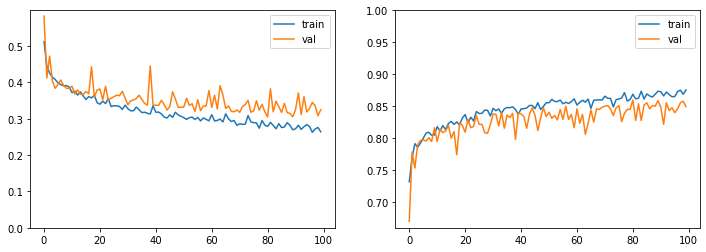

In [17]:
y = np.array([mrk.photo_reqs.varied_background.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'varied_background')
list_model_files.append(model_file)

#### 12. Roll/pitch/yaw

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6333 - accuracy: 0.6670 - precision: 0.8662 - recall: 0.6576 - f1: 0.7407 - specificity: 0.6991 - negative_predictive_value: 0.4117 - matthews_correlation_coefficient: 0.3159 - val_loss: 0.6148 - val_accuracy: 0.6817 - val_precision: 0.8718 - val_recall: 0.6322 - val_f1: 0.7275 - val_specificity: 0.7903 - val_negative_predictive_value: 0.4468 - val_matthews_correlation_coefficient: 0.3646

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.36458, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_20-00_18_24.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6228 - accuracy: 0.6781 - precision: 0.8749 - recall: 0.6674 - f1: 0.7526 - specificity: 0.7148 - negative_predictive_value: 0.4205 - matthews_correlation_coefficient: 0.3339 - val_loss: 0.6188 - val_accuracy: 0.6826 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6045 - accuracy: 0.6837 - precision: 0.8823 - recall: 0.6658 - f1: 0.7552 - specificity: 0.7320 - negative_predictive_value: 0.4265 - matthews_correlation_coefficient: 0.3503 - val_loss: 0.6230 - val_accuracy: 0.6696 - val_precision: 0.8725 - val_recall: 0.6140 - val_f1: 0.7151 - val_specificity: 0.7993 - val_negative_predictive_value: 0.4369 - val_matthews_correlation_coefficient: 0.3553

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36838
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6078 - accuracy: 0.6805 - precision: 0.8764 - recall: 0.6616 - f1: 0.7501 - specificity: 0.7294 - negative_predictive_value: 0.4276 - matthews_correlation_coefficient: 0.3445 - val_loss: 0.6127 - val_accuracy: 0.6800 - val_precision: 0.8732 - val_recall: 0.6290 - val_f1: 0.7261 - val_specificity: 0.7939 - val_negative_predictive_value: 0.4444 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.6015 - accuracy: 0.6798 - precision: 0.8777 - recall: 0.6644 - f1: 0.7527 - specificity: 0.7188 - negative_predictive_value: 0.4226 - matthews_correlation_coefficient: 0.3380 - val_loss: 0.5911 - val_accuracy: 0.6912 - val_precision: 0.8591 - val_recall: 0.6602 - val_f1: 0.7404 - val_specificity: 0.7510 - val_negative_predictive_value: 0.4553 - val_matthews_correlation_coefficient: 0.3571

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.36849
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5991 - accuracy: 0.6872 - precision: 0.8710 - recall: 0.6689 - f1: 0.7526 - specificity: 0.7212 - negative_predictive_value: 0.4322 - matthews_correlation_coefficient: 0.3422 - val_loss: 0.6143 - val_accuracy: 0.6800 - val_precision: 0.8664 - val_recall: 0.6345 - val_f1: 0.7268 - val_specificity: 0.7802 - val_negative_predictive_value: 0.4453 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5952 - accuracy: 0.6798 - precision: 0.8822 - recall: 0.6623 - f1: 0.7510 - specificity: 0.7378 - negative_predictive_value: 0.4348 - matthews_correlation_coefficient: 0.3545 - val_loss: 0.6035 - val_accuracy: 0.6834 - val_precision: 0.8715 - val_recall: 0.6357 - val_f1: 0.7293 - val_specificity: 0.7908 - val_negative_predictive_value: 0.4496 - val_matthews_correlation_coefficient: 0.3675

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.36849
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5953 - accuracy: 0.6839 - precision: 0.8801 - recall: 0.6587 - f1: 0.7484 - specificity: 0.7447 - negative_predictive_value: 0.4383 - matthews_correlation_coefficient: 0.3583 - val_loss: 0.6085 - val_accuracy: 0.6756 - val_precision: 0.8722 - val_recall: 0.6238 - val_f1: 0.7215 - val_specificity: 0.7974 - val_negative_predictive_value: 0.4441 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5888 - accuracy: 0.6922 - precision: 0.8823 - recall: 0.6772 - f1: 0.7621 - specificity: 0.7349 - negative_predictive_value: 0.4431 - matthews_correlation_coefficient: 0.3651 - val_loss: 0.6039 - val_accuracy: 0.6834 - val_precision: 0.8733 - val_recall: 0.6329 - val_f1: 0.7287 - val_specificity: 0.7998 - val_negative_predictive_value: 0.4517 - val_matthews_correlation_coefficient: 0.3727

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.37339
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5884 - accuracy: 0.6889 - precision: 0.8831 - recall: 0.6740 - f1: 0.7597 - specificity: 0.7298 - negative_predictive_value: 0.4346 - matthews_correlation_coefficient: 0.3567 - val_loss: 0.6293 - val_accuracy: 0.6730 - val_precision: 0.8707 - val_recall: 0.6206 - val_f1: 0.7194 - val_specificity: 0.7973 - val_negative_predictive_value: 0.4422 - val_matthews_correlation_coefficie


Epoch 00073: val_matthews_correlation_coefficient improved from 0.37633 to 0.37716, saving model to ../models/autoencoders_requirements/roll_pitch_yaw_2020_03_20-00_18_24.h5
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5827 - accuracy: 0.6965 - precision: 0.8886 - recall: 0.6772 - f1: 0.7647 - specificity: 0.7516 - negative_predictive_value: 0.4427 - matthews_correlation_coefficient: 0.3767 - val_loss: 0.6210 - val_accuracy: 0.6800 - val_precision: 0.8753 - val_recall: 0.6278 - val_f1: 0.7253 - val_specificity: 0.8046 - val_negative_predictive_value: 0.4489 - val_matthews_correlation_coefficient: 0.3720

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.37716
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5825 - accuracy: 0.6931 - precision: 0.8887 - recall: 0.6749 - f1: 0.7623 - specificity: 0.7565 - negative_predictive_value: 0.4486 - matthews_correlation_coefficient: 0.3793 - val_loss: 0.6419


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.37716
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5792 - accuracy: 0.6970 - precision: 0.8787 - recall: 0.6771 - f1: 0.7607 - specificity: 0.7336 - negative_predictive_value: 0.4402 - matthews_correlation_coefficient: 0.3669 - val_loss: 0.7010 - val_accuracy: 0.6097 - val_precision: 0.8758 - val_recall: 0.5213 - val_f1: 0.6474 - val_specificity: 0.8380 - val_negative_predictive_value: 0.3961 - val_matthews_correlation_coefficient: 0.3101

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.37716
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5873 - accuracy: 0.6857 - precision: 0.8909 - recall: 0.6608 - f1: 0.7506 - specificity: 0.7639 - negative_predictive_value: 0.4466 - matthews_correlation_coefficient: 0.3770 - val_loss: 0.6081 - val_accuracy: 0.6834 - val_precision: 0.8681 - val_recall: 0.6393 - val_f1: 0.7308 - val_spe

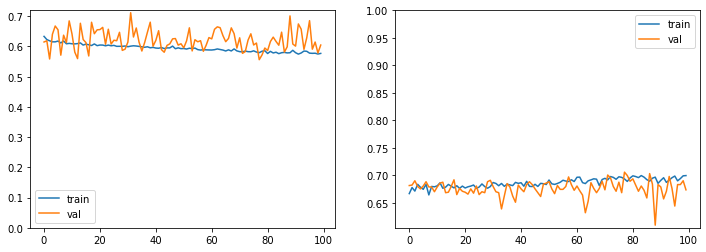

In [18]:
y = np.array([mrk.photo_reqs.roll_pitch_yaw.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'roll_pitch_yaw')
list_model_files.append(model_file)

#### 13. Flash Reflection on Skin

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6350 - accuracy: 0.6328 - precision: 0.7204 - recall: 0.5862 - f1: 0.6128 - specificity: 0.6825 - negative_predictive_value: 0.5512 - matthews_correlation_coefficient: 0.2812 - val_loss: 0.5961 - val_accuracy: 0.6652 - val_precision: 0.7250 - val_recall: 0.6403 - val_f1: 0.6740 - val_specificity: 0.6870 - val_negative_predictive_value: 0.5881 - val_matthews_correlation_coefficient: 0.3197

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31971, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_20-00_33_12.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5813 - accuracy: 0.6870 - precision: 0.7700 - recall: 0.6978 - f1: 0.7173 - specificity: 0.6770 - negative_predictive_value: 0.6179 - matthews_correlation_coefficient: 0.3820 - val_loss: 0.5539 - val_accuracy: 0.7415 - 


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.46417
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5080 - accuracy: 0.7529 - precision: 0.8117 - recall: 0.7746 - f1: 0.7846 - specificity: 0.7290 - negative_predictive_value: 0.6929 - matthews_correlation_coefficient: 0.5034 - val_loss: 0.5770 - val_accuracy: 0.7129 - val_precision: 0.7898 - val_recall: 0.6542 - val_f1: 0.7098 - val_specificity: 0.7796 - val_negative_predictive_value: 0.6256 - val_matthews_correlation_coefficient: 0.4240

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.46417
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4944 - accuracy: 0.7631 - precision: 0.8176 - recall: 0.7849 - f1: 0.7925 - specificity: 0.7361 - negative_predictive_value: 0.7072 - matthews_correlation_coefficient: 0.5223 - val_loss: 0.5165 - val_accuracy: 0.7563 - val_precision: 0.7711 - val_recall: 0.7735 - val_f1: 0.7679 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4754 - accuracy: 0.7740 - precision: 0.8161 - recall: 0.7933 - f1: 0.7979 - specificity: 0.7410 - negative_predictive_value: 0.7120 - matthews_correlation_coefficient: 0.5371 - val_loss: 0.5409 - val_accuracy: 0.7320 - val_precision: 0.8136 - val_recall: 0.6617 - val_f1: 0.7236 - val_specificity: 0.8124 - val_negative_predictive_value: 0.6421 - val_matthews_correlation_coefficient: 0.4642

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.49607
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4803 - accuracy: 0.7694 - precision: 0.8278 - recall: 0.7826 - f1: 0.7986 - specificity: 0.7617 - negative_predictive_value: 0.7050 - matthews_correlation_coefficient: 0.5379 - val_loss: 0.5113 - val_accuracy: 0.7589 - val_precision: 0.7579 - val_recall: 0.8060 - val_f1: 0.7766 - val_specificity: 0.6746 - val_negative_predictive_value: 0.7328 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.51783
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4593 - accuracy: 0.7855 - precision: 0.8421 - recall: 0.7935 - f1: 0.8121 - specificity: 0.7796 - negative_predictive_value: 0.7189 - matthews_correlation_coefficient: 0.5665 - val_loss: 0.5019 - val_accuracy: 0.7771 - val_precision: 0.7843 - val_recall: 0.8002 - val_f1: 0.7880 - val_specificity: 0.7239 - val_negative_predictive_value: 0.7363 - val_matthews_correlation_coefficient: 0.5219

Epoch 00044: val_matthews_correlation_coefficient improved from 0.51783 to 0.52188, saving model to ../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_20-00_33_12.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4625 - accuracy: 0.7852 - precision: 0.8380 - recall: 0.7855 - f1: 0.8054 - specificity: 0.7767 - negative_predictive_value: 0.7126 - matthews_correlation_coefficient: 0.5558 - val_lo


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.52188
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4506 - accuracy: 0.7913 - precision: 0.8449 - recall: 0.7833 - f1: 0.8057 - specificity: 0.8021 - negative_predictive_value: 0.7262 - matthews_correlation_coefficient: 0.5790 - val_loss: 0.5096 - val_accuracy: 0.7537 - val_precision: 0.7870 - val_recall: 0.7405 - val_f1: 0.7585 - val_specificity: 0.7522 - val_negative_predictive_value: 0.6891 - val_matthews_correlation_coefficient: 0.4838

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.52188
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4522 - accuracy: 0.7922 - precision: 0.8365 - recall: 0.7970 - f1: 0.8112 - specificity: 0.7817 - negative_predictive_value: 0.7332 - matthews_correlation_coefficient: 0.5736 - val_loss: 0.5018 - val_accuracy: 0.7563 - val_precision: 0.8043 - val_recall: 0.7248 - val_f1: 0.7582 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.52979
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4435 - accuracy: 0.7926 - precision: 0.8472 - recall: 0.8034 - f1: 0.8189 - specificity: 0.7818 - negative_predictive_value: 0.7304 - matthews_correlation_coefficient: 0.5808 - val_loss: 0.5034 - val_accuracy: 0.7546 - val_precision: 0.7912 - val_recall: 0.7394 - val_f1: 0.7592 - val_specificity: 0.7585 - val_negative_predictive_value: 0.6885 - val_matthews_correlation_coefficient: 0.4883

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.52979
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4372 - accuracy: 0.7928 - precision: 0.8500 - recall: 0.7984 - f1: 0.8188 - specificity: 0.7927 - negative_predictive_value: 0.7260 - matthews_correlation_coefficient: 0.5830 - val_loss: 0.5018 - val_accuracy: 0.7606 - val_precision: 0.7822 - val_recall: 0.7700 - val_f1: 0.7708 - val_spe


Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.53045
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4318 - accuracy: 0.8015 - precision: 0.8550 - recall: 0.8110 - f1: 0.8279 - specificity: 0.7962 - negative_predictive_value: 0.7411 - matthews_correlation_coefficient: 0.6011 - val_loss: 0.4925 - val_accuracy: 0.7624 - val_precision: 0.7570 - val_recall: 0.8205 - val_f1: 0.7819 - val_specificity: 0.6623 - val_negative_predictive_value: 0.7481 - val_matthews_correlation_coefficient: 0.4929

Epoch 00089: val_matthews_correlation_coefficient did not improve from 0.53045
Epoch 90/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4311 - accuracy: 0.8024 - precision: 0.8505 - recall: 0.8043 - f1: 0.8207 - specificity: 0.7954 - negative_predictive_value: 0.7442 - matthews_correlation_coefficient: 0.5982 - val_loss: 0.5335 - val_accuracy: 0.7511 - val_precision: 0.7773 - val_recall: 0.7615 - val_f1: 0.7638 - val_spe

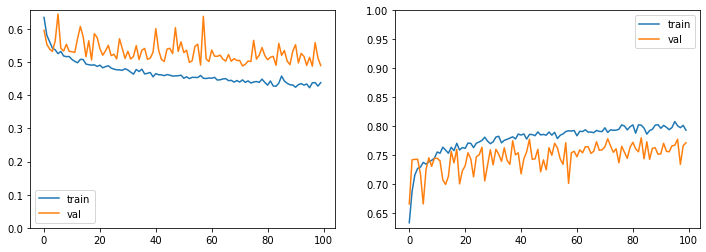

In [19]:
y = np.array([mrk.photo_reqs.flash_reflection_on_skin.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_skin')
list_model_files.append(model_file)

#### 14. Red Eyes 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6456 - accuracy: 0.5280 - precision: 0.9045 - recall: 0.4554 - f1: 0.5986 - specificity: 0.8258 - negative_predictive_value: 0.2732 - matthews_correlation_coefficient: 0.2272 - val_loss: 0.6830 - val_accuracy: 0.4588 - val_precision: 0.8925 - val_recall: 0.3440 - val_f1: 0.4890 - val_specificity: 0.8765 - val_negative_predictive_value: 0.2712 - val_matthews_correlation_coefficient: 0.1865

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.18647, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_20-00_48_04.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6372 - accuracy: 0.5299 - precision: 0.9090 - recall: 0.4642 - f1: 0.6040 - specificity: 0.8018 - negative_predictive_value: 0.2688 - matthews_correlation_coefficient: 0.2157 - val_loss: 0.6295 - val_accuracy: 0.5317 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.32323
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5806 - accuracy: 0.6449 - precision: 0.9233 - recall: 0.6140 - f1: 0.7301 - specificity: 0.7884 - negative_predictive_value: 0.3369 - matthews_correlation_coefficient: 0.3198 - val_loss: 0.5450 - val_accuracy: 0.6782 - val_precision: 0.8865 - val_recall: 0.6431 - val_f1: 0.7428 - val_specificity: 0.7454 - val_negative_predictive_value: 0.3681 - val_matthews_correlation_coefficient: 0.3120

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32323
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5822 - accuracy: 0.6438 - precision: 0.9254 - recall: 0.6067 - f1: 0.7220 - specificity: 0.7881 - negative_predictive_value: 0.3362 - matthews_correlation_coefficient: 0.3191 - val_loss: 0.6669 - val_accuracy: 0.5533 - val_precision: 0.9262 - val_recall: 0.4524 - val_f1: 0.6013 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5507 - accuracy: 0.6633 - precision: 0.9288 - recall: 0.6299 - f1: 0.7424 - specificity: 0.7809 - negative_predictive_value: 0.3492 - matthews_correlation_coefficient: 0.3370 - val_loss: 0.4680 - val_accuracy: 0.7381 - val_precision: 0.8696 - val_recall: 0.7416 - val_f1: 0.7979 - val_specificity: 0.6550 - val_negative_predictive_value: 0.4190 - val_matthews_correlation_coefficient: 0.3357

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.37217
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5441 - accuracy: 0.6896 - precision: 0.9268 - recall: 0.6691 - f1: 0.7699 - specificity: 0.7778 - negative_predictive_value: 0.3763 - matthews_correlation_coefficient: 0.3658 - val_loss: 0.5224 - val_accuracy: 0.6869 - val_precision: 0.9038 - val_recall: 0.6397 - val_f1: 0.7470 - val_specificity: 0.7947 - val_negative_predictive_value: 0.3789 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38731
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5324 - accuracy: 0.6879 - precision: 0.9215 - recall: 0.6720 - f1: 0.7690 - specificity: 0.7461 - negative_predictive_value: 0.3662 - matthews_correlation_coefficient: 0.3455 - val_loss: 0.4899 - val_accuracy: 0.7389 - val_precision: 0.8986 - val_recall: 0.7146 - val_f1: 0.7940 - val_specificity: 0.7609 - val_negative_predictive_value: 0.4329 - val_matthews_correlation_coefficient: 0.3937

Epoch 00044: val_matthews_correlation_coefficient improved from 0.38731 to 0.39375, saving model to ../models/autoencoders_requirements/red_eyes_2020_03_20-00_48_04.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5309 - accuracy: 0.6950 - precision: 0.9200 - recall: 0.6725 - f1: 0.7700 - specificity: 0.7744 - negative_predictive_value: 0.3791 - matthews_correlation_coefficient: 0.3610 - val_loss: 0.5753 - val

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5097 - accuracy: 0.7132 - precision: 0.9295 - recall: 0.6969 - f1: 0.7894 - specificity: 0.7760 - negative_predictive_value: 0.4004 - matthews_correlation_coefficient: 0.3929 - val_loss: 0.5208 - val_accuracy: 0.6964 - val_precision: 0.9021 - val_recall: 0.6520 - val_f1: 0.7546 - val_specificity: 0.8018 - val_negative_predictive_value: 0.3908 - val_matthews_correlation_coefficient: 0.3620

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41505
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5150 - accuracy: 0.7063 - precision: 0.9280 - recall: 0.6882 - f1: 0.7820 - specificity: 0.7789 - negative_predictive_value: 0.3933 - matthews_correlation_coefficient: 0.3852 - val_loss: 0.5299 - val_accuracy: 0.6895 - val_precision: 0.9046 - val_recall: 0.6404 - val_f1: 0.7469 - val_specificity: 0.8091 - val_negative_predictive_value: 0.3886 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4908 - accuracy: 0.7273 - precision: 0.9317 - recall: 0.7173 - f1: 0.8044 - specificity: 0.7719 - negative_predictive_value: 0.4114 - matthews_correlation_coefficient: 0.4055 - val_loss: 0.5149 - val_accuracy: 0.7025 - val_precision: 0.9005 - val_recall: 0.6615 - val_f1: 0.7603 - val_specificity: 0.7934 - val_negative_predictive_value: 0.3965 - val_matthews_correlation_coefficient: 0.3650

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41505
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5076 - accuracy: 0.7161 - precision: 0.9284 - recall: 0.7023 - f1: 0.7922 - specificity: 0.7773 - negative_predictive_value: 0.4033 - matthews_correlation_coefficient: 0.3950 - val_loss: 0.5366 - val_accuracy: 0.6878 - val_precision: 0.9096 - val_recall: 0.6325 - val_f1: 0.7423 - val_specificity: 0.8286 - val_negative_predictive_value: 0.3885 - val_matthews_correlation_coefficie


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.41505
Epoch 00087: early stopping

   Final Accuracy:  75.54%
  Final Precision:  92.90%
     Final Recall:  75.19%
  Final F-measure:  83.11%
Final Specificity:  76.96%
        Final NPV:  43.60%
        Final MCC:  43.63%
[[177  53]
 [229 694]]
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       230
           1       0.93      0.75      0.83       923

    accuracy                           0.76      1153
   macro avg       0.68      0.76      0.69      1153
weighted avg       0.83      0.76      0.78      1153



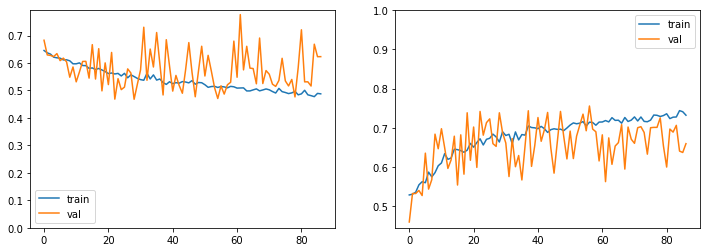

In [20]:
y = np.array([mrk.photo_reqs.red_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'red_eyes')
list_model_files.append(model_file)

#### 15. Shadows Behind Head 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5667 - accuracy: 0.6636 - precision: 0.8794 - recall: 0.6572 - f1: 0.7344 - specificity: 0.6719 - negative_predictive_value: 0.3708 - matthews_correlation_coefficient: 0.2950 - val_loss: 0.5117 - val_accuracy: 0.7138 - val_precision: 0.8712 - val_recall: 0.6884 - val_f1: 0.7657 - val_specificity: 0.7137 - val_negative_predictive_value: 0.4338 - val_matthews_correlation_coefficient: 0.3762

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.37619, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_20-01_01_02.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5348 - accuracy: 0.6811 - precision: 0.9063 - recall: 0.6580 - f1: 0.7483 - specificity: 0.7673 - negative_predictive_value: 0.4306 - matthews_correlation_coefficient: 0.3760 - val_loss: 0.5048 - val_accuracy: 0.7329 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4837 - accuracy: 0.7343 - precision: 0.9112 - recall: 0.7209 - f1: 0.7987 - specificity: 0.7799 - negative_predictive_value: 0.4842 - matthews_correlation_coefficient: 0.4434 - val_loss: 0.4383 - val_accuracy: 0.7823 - val_precision: 0.8746 - val_recall: 0.7839 - val_f1: 0.8237 - val_specificity: 0.7047 - val_negative_predictive_value: 0.5300 - val_matthews_correlation_coefficient: 0.4696

Epoch 00015: val_matthews_correlation_coefficient improved from 0.46768 to 0.46956, saving model to ../models/autoencoders_requirements/shadows_behind_head_2020_03_20-01_01_02.h5
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4810 - accuracy: 0.7310 - precision: 0.9022 - recall: 0.7173 - f1: 0.7922 - specificity: 0.7674 - negative_predictive_value: 0.4756 - matthews_correlation_coefficient: 0.4313 - val_loss: 0.5370 - val_accuracy: 0.6375 - val_precision: 0.9130 - val_recall: 0.5458 - val_f1: 0.6775 - 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4681 - accuracy: 0.7458 - precision: 0.9147 - recall: 0.7374 - f1: 0.8098 - specificity: 0.7865 - negative_predictive_value: 0.4885 - matthews_correlation_coefficient: 0.4579 - val_loss: 0.4983 - val_accuracy: 0.7112 - val_precision: 0.9347 - val_recall: 0.6291 - val_f1: 0.7486 - val_specificity: 0.8959 - val_negative_predictive_value: 0.4428 - val_matthews_correlation_coefficient: 0.4705

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.51304
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4705 - accuracy: 0.7443 - precision: 0.9185 - recall: 0.7346 - f1: 0.8103 - specificity: 0.7885 - negative_predictive_value: 0.4914 - matthews_correlation_coefficient: 0.4607 - val_loss: 0.4040 - val_accuracy: 0.8049 - val_precision: 0.8388 - val_recall: 0.8621 - val_f1: 0.8481 - val_specificity: 0.5428 - val_negative_predictive_value: 0.6042 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4410 - accuracy: 0.7646 - precision: 0.9216 - recall: 0.7561 - f1: 0.8234 - specificity: 0.8013 - negative_predictive_value: 0.5158 - matthews_correlation_coefficient: 0.4916 - val_loss: 0.3991 - val_accuracy: 0.8049 - val_precision: 0.8713 - val_recall: 0.8194 - val_f1: 0.8410 - val_specificity: 0.6729 - val_negative_predictive_value: 0.5911 - val_matthews_correlation_coefficient: 0.5008

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.51304
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4356 - accuracy: 0.7735 - precision: 0.9306 - recall: 0.7635 - f1: 0.8344 - specificity: 0.8147 - negative_predictive_value: 0.5217 - matthews_correlation_coefficient: 0.5084 - val_loss: 0.4301 - val_accuracy: 0.7563 - val_precision: 0.8695 - val_recall: 0.7499 - val_f1: 0.8016 - val_specificity: 0.6979 - val_negative_predictive_value: 0.4974 - val_matthews_correlation_coefficie

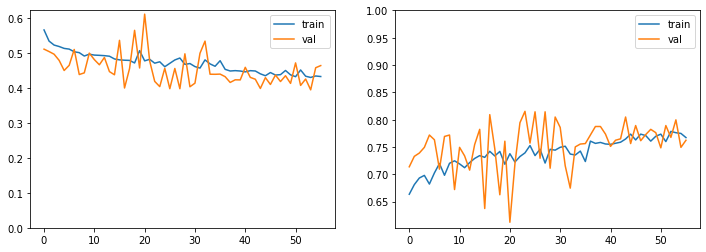

In [21]:
y = np.array([mrk.photo_reqs.shadows_behind_head.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_behind_head')
list_model_files.append(model_file)

#### 16. Shadows Across Face

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6244 - accuracy: 0.5714 - precision: 0.9045 - recall: 0.5232 - f1: 0.6539 - specificity: 0.7794 - negative_predictive_value: 0.2866 - matthews_correlation_coefficient: 0.2378 - val_loss: 0.5783 - val_accuracy: 0.5811 - val_precision: 0.9063 - val_recall: 0.5006 - val_f1: 0.6387 - val_specificity: 0.8449 - val_negative_predictive_value: 0.3153 - val_matthews_correlation_coefficient: 0.2739

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.27390, saving model to ../models/autoencoders_requirements/shadows_across_face_2020_03_20-01_09_25.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6033 - accuracy: 0.5998 - precision: 0.9222 - recall: 0.5514 - f1: 0.6833 - specificity: 0.7876 - negative_predictive_value: 0.3062 - matthews_correlation_coefficient: 0.2771 - val_loss: 0.5474 - val_accuracy: 0.6210 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5602 - accuracy: 0.6581 - precision: 0.9327 - recall: 0.6220 - f1: 0.7369 - specificity: 0.7984 - negative_predictive_value: 0.3451 - matthews_correlation_coefficient: 0.3406 - val_loss: 0.5690 - val_accuracy: 0.6826 - val_precision: 0.9025 - val_recall: 0.6341 - val_f1: 0.7417 - val_specificity: 0.8102 - val_negative_predictive_value: 0.3787 - val_matthews_correlation_coefficient: 0.3510

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36278
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5544 - accuracy: 0.6720 - precision: 0.9325 - recall: 0.6384 - f1: 0.7520 - specificity: 0.8109 - negative_predictive_value: 0.3575 - matthews_correlation_coefficient: 0.3584 - val_loss: 0.5170 - val_accuracy: 0.7199 - val_precision: 0.8851 - val_recall: 0.7021 - val_f1: 0.7804 - val_specificity: 0.7228 - val_negative_predictive_value: 0.3999 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5371 - accuracy: 0.6646 - precision: 0.9345 - recall: 0.6308 - f1: 0.7460 - specificity: 0.8221 - negative_predictive_value: 0.3603 - matthews_correlation_coefficient: 0.3615 - val_loss: 0.5986 - val_accuracy: 0.6600 - val_precision: 0.9285 - val_recall: 0.5902 - val_f1: 0.7167 - val_specificity: 0.8749 - val_negative_predictive_value: 0.3696 - val_matthews_correlation_coefficient: 0.3694

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.39780
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5254 - accuracy: 0.6798 - precision: 0.9388 - recall: 0.6474 - f1: 0.7609 - specificity: 0.8230 - negative_predictive_value: 0.3661 - matthews_correlation_coefficient: 0.3768 - val_loss: 0.4835 - val_accuracy: 0.7138 - val_precision: 0.8671 - val_recall: 0.7094 - val_f1: 0.7784 - val_specificity: 0.6571 - val_negative_predictive_value: 0.3827 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5123 - accuracy: 0.6885 - precision: 0.9429 - recall: 0.6526 - f1: 0.7650 - specificity: 0.8520 - negative_predictive_value: 0.3770 - matthews_correlation_coefficient: 0.3996 - val_loss: 0.5518 - val_accuracy: 0.6678 - val_precision: 0.9159 - val_recall: 0.6089 - val_f1: 0.7272 - val_specificity: 0.8360 - val_negative_predictive_value: 0.3714 - val_matthews_correlation_coefficient: 0.3552

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.39780
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5124 - accuracy: 0.6790 - precision: 0.9457 - recall: 0.6376 - f1: 0.7556 - specificity: 0.8333 - negative_predictive_value: 0.3689 - matthews_correlation_coefficient: 0.3849 - val_loss: 0.4581 - val_accuracy: 0.7285 - val_precision: 0.8633 - val_recall: 0.7350 - val_f1: 0.7921 - val_specificity: 0.6247 - val_negative_predictive_value: 0.3922 - val_matthews_correlation_coefficie


Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.39780
Epoch 00057: early stopping

   Final Accuracy:  68.86%
  Final Precision:  95.50%
     Final Recall:  64.22%
  Final F-measure:  76.79%
Final Specificity:  87.72%
        Final NPV:  37.66%
        Final MCC:  41.50%
[[200  28]
 [331 594]]
              precision    recall  f1-score   support

           0       0.38      0.88      0.53       228
           1       0.95      0.64      0.77       925

    accuracy                           0.69      1153
   macro avg       0.67      0.76      0.65      1153
weighted avg       0.84      0.69      0.72      1153



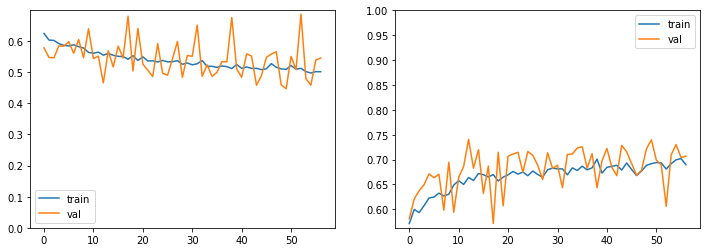

In [22]:
y = np.array([mrk.photo_reqs.shadows_across_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'shadows_across_face')
list_model_files.append(model_file)

#### 17. Dark Tinted Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 29s 6ms/step - loss: 0.5817 - accuracy: 0.5360 - precision: 0.9654 - recall: 0.5001 - f1: 0.6524 - specificity: 0.8647 - negative_predictive_value: 0.1813 - matthews_correlation_coefficient: 0.2281 - val_loss: 0.7151 - val_accuracy: 0.4692 - val_precision: 0.9443 - val_recall: 0.4046 - val_f1: 0.5611 - val_specificity: 0.8662 - val_negative_predictive_value: 0.1546 - val_matthews_correlation_coefficient: 0.1917

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.19168, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_20-01_17_59.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5610 - accuracy: 0.5629 - precision: 0.9680 - recall: 0.5274 - f1: 0.6747 - specificity: 0.8279 - negative_predictive_value: 0.1851 - matthews_correlation_coefficient: 0.2332 - val_loss: 0.5888 - val_accuracy: 0.5256 - val_pr

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4703 - accuracy: 0.7065 - precision: 0.9708 - recall: 0.6937 - f1: 0.8009 - specificity: 0.8253 - negative_predictive_value: 0.2695 - matthews_correlation_coefficient: 0.3440 - val_loss: 0.4855 - val_accuracy: 0.6999 - val_precision: 0.9443 - val_recall: 0.6641 - val_f1: 0.7773 - val_specificity: 0.8324 - val_negative_predictive_value: 0.2414 - val_matthews_correlation_coefficient: 0.3272

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.32763
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4656 - accuracy: 0.7200 - precision: 0.9646 - recall: 0.7064 - f1: 0.8081 - specificity: 0.8214 - negative_predictive_value: 0.2779 - matthews_correlation_coefficient: 0.3564 - val_loss: 0.4930 - val_accuracy: 0.6834 - val_precision: 0.9414 - val_recall: 0.6467 - val_f1: 0.7637 - val_specificity: 0.8176 - val_negative_predictive_value: 0.2324 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4104 - accuracy: 0.7577 - precision: 0.9766 - recall: 0.7501 - f1: 0.8412 - specificity: 0.8235 - negative_predictive_value: 0.3166 - matthews_correlation_coefficient: 0.4007 - val_loss: 0.2784 - val_accuracy: 0.8760 - val_precision: 0.9313 - val_recall: 0.8768 - val_f1: 0.9025 - val_specificity: 0.6829 - val_negative_predictive_value: 0.4435 - val_matthews_correlation_coefficient: 0.4706

Epoch 00029: val_matthews_correlation_coefficient improved from 0.43389 to 0.47059, saving model to ../models/autoencoders_requirements/dark_tinted_lenses_2020_03_20-01_17_59.h5
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3988 - accuracy: 0.7764 - precision: 0.9781 - recall: 0.7684 - f1: 0.8541 - specificity: 0.8417 - negative_predictive_value: 0.3438 - matthews_correlation_coefficient: 0.4324 - val_loss: 0.4118 - val_accuracy: 0.7580 - val_precision: 0.9503 - val_recall: 0.7246 - val_f1: 0.8202 - v


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.47059
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3859 - accuracy: 0.7855 - precision: 0.9783 - recall: 0.7784 - f1: 0.8597 - specificity: 0.8150 - negative_predictive_value: 0.3509 - matthews_correlation_coefficient: 0.4317 - val_loss: 0.4087 - val_accuracy: 0.7520 - val_precision: 0.9602 - val_recall: 0.7115 - val_f1: 0.8146 - val_specificity: 0.9113 - val_negative_predictive_value: 0.3207 - val_matthews_correlation_coefficient: 0.4093

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.47059
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3754 - accuracy: 0.7907 - precision: 0.9793 - recall: 0.7802 - f1: 0.8634 - specificity: 0.8689 - negative_predictive_value: 0.3532 - matthews_correlation_coefficient: 0.4545 - val_loss: 0.6884 - val_accuracy: 0.6253 - val_precision: 0.9656 - val_recall: 0.5655 - val_f1: 0.7086 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.53098
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3737 - accuracy: 0.7935 - precision: 0.9810 - recall: 0.7857 - f1: 0.8658 - specificity: 0.8596 - negative_predictive_value: 0.3755 - matthews_correlation_coefficient: 0.4689 - val_loss: 0.5410 - val_accuracy: 0.6791 - val_precision: 0.9696 - val_recall: 0.6218 - val_f1: 0.7546 - val_specificity: 0.9622 - val_negative_predictive_value: 0.2674 - val_matthews_correlation_coefficient: 0.3652

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.53098
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3722 - accuracy: 0.7935 - precision: 0.9814 - recall: 0.7867 - f1: 0.8681 - specificity: 0.8728 - negative_predictive_value: 0.3618 - matthews_correlation_coefficient: 0.4630 - val_loss: 0.6413 - val_accuracy: 0.6349 - val_precision: 0.9666 - val_recall: 0.5757 - val_f1: 0.7158 - val_spe


Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.53098
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3448 - accuracy: 0.8074 - precision: 0.9831 - recall: 0.7978 - f1: 0.8753 - specificity: 0.8658 - negative_predictive_value: 0.3877 - matthews_correlation_coefficient: 0.4859 - val_loss: 0.5682 - val_accuracy: 0.6722 - val_precision: 0.9716 - val_recall: 0.6148 - val_f1: 0.7495 - val_specificity: 0.9676 - val_negative_predictive_value: 0.2685 - val_matthews_correlation_coefficient: 0.3667

Epoch 00074: val_matthews_correlation_coefficient did not improve from 0.53098
Epoch 75/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3307 - accuracy: 0.8163 - precision: 0.9829 - recall: 0.8101 - f1: 0.8844 - specificity: 0.8790 - negative_predictive_value: 0.3879 - matthews_correlation_coefficient: 0.4953 - val_loss: 0.4260 - val_accuracy: 0.7546 - val_precision: 0.9645 - val_recall: 0.7099 - val_f1: 0.8147 - val_spe

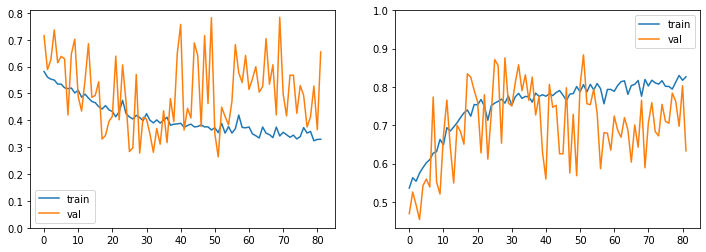

In [23]:
y = np.array([mrk.photo_reqs.dark_tinted_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'dark_tinted_lenses')
list_model_files.append(model_file)

#### 18. Flash Reflection on Lenses

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5883 - accuracy: 0.6542 - precision: 0.9058 - recall: 0.6324 - f1: 0.7332 - specificity: 0.7262 - negative_predictive_value: 0.3473 - matthews_correlation_coefficient: 0.3032 - val_loss: 0.6320 - val_accuracy: 0.6305 - val_precision: 0.9059 - val_recall: 0.6080 - val_f1: 0.7214 - val_specificity: 0.7400 - val_negative_predictive_value: 0.3299 - val_matthews_correlation_coefficient: 0.2851

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.28509, saving model to ../models/autoencoders_requirements/flash_reflection_on_lenses_2020_03_20-01_30_41.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5734 - accuracy: 0.6746 - precision: 0.8990 - recall: 0.6621 - f1: 0.7542 - specificity: 0.7199 - negative_predictive_value: 0.3688 - matthews_correlation_coefficient: 0.3173 - val_loss: 0.6145 - val_accuracy: 0.6626 

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5293 - accuracy: 0.7043 - precision: 0.9143 - recall: 0.6924 - f1: 0.7786 - specificity: 0.7541 - negative_predictive_value: 0.4027 - matthews_correlation_coefficient: 0.3729 - val_loss: 0.6324 - val_accuracy: 0.6019 - val_precision: 0.9458 - val_recall: 0.5402 - val_f1: 0.6819 - val_specificity: 0.8661 - val_negative_predictive_value: 0.3281 - val_matthews_correlation_coefficient: 0.3321

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.34869
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5218 - accuracy: 0.7024 - precision: 0.9245 - recall: 0.6800 - f1: 0.7773 - specificity: 0.7771 - negative_predictive_value: 0.4014 - matthews_correlation_coefficient: 0.3839 - val_loss: 0.5789 - val_accuracy: 0.6748 - val_precision: 0.9249 - val_recall: 0.6524 - val_f1: 0.7603 - val_specificity: 0.7800 - val_negative_predictive_value: 0.3697 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5320 - accuracy: 0.6876 - precision: 0.9239 - recall: 0.6654 - f1: 0.7588 - specificity: 0.7694 - negative_predictive_value: 0.4014 - matthews_correlation_coefficient: 0.3710 - val_loss: 0.5184 - val_accuracy: 0.7086 - val_precision: 0.9174 - val_recall: 0.7049 - val_f1: 0.7935 - val_specificity: 0.7464 - val_negative_predictive_value: 0.3951 - val_matthews_correlation_coefficient: 0.3738

Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.38195
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5042 - accuracy: 0.7291 - precision: 0.9202 - recall: 0.7193 - f1: 0.8001 - specificity: 0.7615 - negative_predictive_value: 0.4305 - matthews_correlation_coefficient: 0.4069 - val_loss: 0.6693 - val_accuracy: 0.6435 - val_precision: 0.9367 - val_recall: 0.6015 - val_f1: 0.7272 - val_specificity: 0.8323 - val_negative_predictive_value: 0.3521 - val_matthews_correlation_coefficie


Epoch 00042: val_matthews_correlation_coefficient did not improve from 0.38457
Epoch 43/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4828 - accuracy: 0.7538 - precision: 0.9230 - recall: 0.7525 - f1: 0.8227 - specificity: 0.7552 - negative_predictive_value: 0.4569 - matthews_correlation_coefficient: 0.4367 - val_loss: 0.6811 - val_accuracy: 0.6175 - val_precision: 0.9433 - val_recall: 0.5631 - val_f1: 0.6995 - val_specificity: 0.8542 - val_negative_predictive_value: 0.3366 - val_matthews_correlation_coefficient: 0.3404

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.38457
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4932 - accuracy: 0.7382 - precision: 0.9179 - recall: 0.7267 - f1: 0.8028 - specificity: 0.7774 - negative_predictive_value: 0.4534 - matthews_correlation_coefficient: 0.4294 - val_loss: 0.5480 - val_accuracy: 0.7008 - val_precision: 0.9287 - val_recall: 0.6833 - val_f1: 0.7831 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4675 - accuracy: 0.7508 - precision: 0.9240 - recall: 0.7469 - f1: 0.8198 - specificity: 0.7534 - negative_predictive_value: 0.4485 - matthews_correlation_coefficient: 0.4275 - val_loss: 0.6275 - val_accuracy: 0.6513 - val_precision: 0.9408 - val_recall: 0.6076 - val_f1: 0.7338 - val_specificity: 0.8391 - val_negative_predictive_value: 0.3580 - val_matthews_correlation_coefficient: 0.3637

Epoch 00057: val_matthews_correlation_coefficient did not improve from 0.41098
Epoch 58/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4712 - accuracy: 0.7568 - precision: 0.9211 - recall: 0.7590 - f1: 0.8256 - specificity: 0.7432 - negative_predictive_value: 0.4585 - matthews_correlation_coefficient: 0.4353 - val_loss: 0.8799 - val_accuracy: 0.5924 - val_precision: 0.9564 - val_recall: 0.5205 - val_f1: 0.6667 - val_specificity: 0.8891 - val_negative_predictive_value: 0.3265 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4583 - accuracy: 0.7588 - precision: 0.9340 - recall: 0.7504 - f1: 0.8252 - specificity: 0.7895 - negative_predictive_value: 0.4732 - matthews_correlation_coefficient: 0.4646 - val_loss: 0.4911 - val_accuracy: 0.7294 - val_precision: 0.9108 - val_recall: 0.7390 - val_f1: 0.8128 - val_specificity: 0.7125 - val_negative_predictive_value: 0.4172 - val_matthews_correlation_coefficient: 0.3826

Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41098
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4533 - accuracy: 0.7640 - precision: 0.9287 - recall: 0.7610 - f1: 0.8314 - specificity: 0.7668 - negative_predictive_value: 0.4701 - matthews_correlation_coefficient: 0.4561 - val_loss: 0.6452 - val_accuracy: 0.6331 - val_precision: 0.9560 - val_recall: 0.5728 - val_f1: 0.7111 - val_specificity: 0.8810 - val_negative_predictive_value: 0.3492 - val_matthews_correlation_coefficie

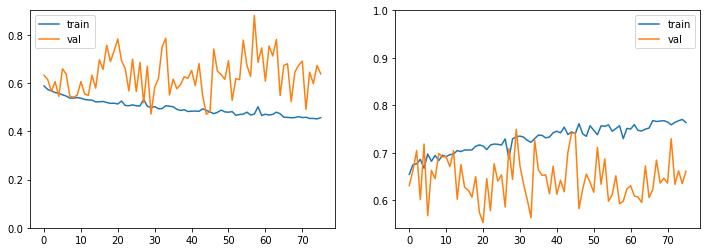

In [24]:
y = np.array([mrk.photo_reqs.flash_reflection_on_lenses.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'flash_reflection_on_lenses')
list_model_files.append(model_file)

#### 19. Frames Too Heavy

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.7707 - accuracy: 0.6262 - precision: 0.9973 - recall: 0.6290 - f1: 0.7397 - specificity: 0.0690 - negative_predictive_value: 0.0046 - matthews_correlation_coefficient: 0.0072 - val_loss: 0.2932 - val_accuracy: 0.9957 - val_precision: 0.9958 - val_recall: 1.0000 - val_f1: 0.9979 - val_specificity: 0.0000e+00 - val_negative_predictive_value: 0.0000e+00 - val_matthews_correlation_coefficient: 0.0000e+00

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.00000, saving model to ../models/autoencoders_requirements/frames_too_heavy_2020_03_20-01_42_08.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.6700 - accuracy: 0.6178 - precision: 0.9976 - recall: 0.6176 - f1: 0.7367 - specificity: 0.0690 - negative_predictive_value: 0.0070 - matthews_correlation_coefficient: 0.0110 - val_loss: 0.4138 - val_accuracy: 0.813

4610/4610 [==============================] - 9s 2ms/step - loss: 0.3912 - accuracy: 0.7866 - precision: 0.9992 - recall: 0.7878 - f1: 0.8775 - specificity: 0.0966 - negative_predictive_value: 0.0187 - matthews_correlation_coefficient: 0.0364 - val_loss: 0.3009 - val_accuracy: 0.8569 - val_precision: 0.9990 - val_recall: 0.8608 - val_f1: 0.9239 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0219 - val_matthews_correlation_coefficient: 0.0421

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.07392
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3766 - accuracy: 0.8521 - precision: 0.9989 - recall: 0.8500 - f1: 0.9131 - specificity: 0.1034 - negative_predictive_value: 0.0322 - matthews_correlation_coefficient: 0.0490 - val_loss: 0.7260 - val_accuracy: 0.5629 - val_precision: 0.9983 - val_recall: 0.5734 - val_f1: 0.7237 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0084 - val_matthews_correlation_coefficie


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.07660
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4122 - accuracy: 0.8091 - precision: 0.9993 - recall: 0.8103 - f1: 0.8870 - specificity: 0.1034 - negative_predictive_value: 0.0281 - matthews_correlation_coefficient: 0.0451 - val_loss: 0.1893 - val_accuracy: 0.9211 - val_precision: 0.9991 - val_recall: 0.9236 - val_f1: 0.9595 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0383 - val_matthews_correlation_coefficient: 0.0590

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.07660
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3226 - accuracy: 0.8777 - precision: 0.9992 - recall: 0.8784 - f1: 0.9251 - specificity: 0.1069 - negative_predictive_value: 0.0438 - matthews_correlation_coefficient: 0.0551 - val_loss: 0.1076 - val_accuracy: 0.9827 - val_precision: 0.9991 - val_recall: 0.9838 - val_f1: 0.9914 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2179 - accuracy: 0.9304 - precision: 0.9996 - recall: 0.9310 - f1: 0.9631 - specificity: 0.1103 - negative_predictive_value: 0.0566 - matthews_correlation_coefficient: 0.0749 - val_loss: 0.3226 - val_accuracy: 0.8430 - val_precision: 0.9990 - val_recall: 0.8474 - val_f1: 0.9160 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0248 - val_matthews_correlation_coefficient: 0.0463

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.09078
Epoch 45/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.2555 - accuracy: 0.8896 - precision: 0.9995 - recall: 0.8903 - f1: 0.9399 - specificity: 0.1172 - negative_predictive_value: 0.0373 - matthews_correlation_coefficient: 0.0583 - val_loss: 0.2782 - val_accuracy: 0.8742 - val_precision: 0.9990 - val_recall: 0.8779 - val_f1: 0.9338 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0302 - val_matthews_correlation_coeffici

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2271 - accuracy: 0.8928 - precision: 0.9995 - recall: 0.8936 - f1: 0.9404 - specificity: 0.1172 - negative_predictive_value: 0.0608 - matthews_correlation_coefficient: 0.0758 - val_loss: 0.1442 - val_accuracy: 0.9436 - val_precision: 0.9991 - val_recall: 0.9457 - val_f1: 0.9714 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0450 - val_matthews_correlation_coefficient: 0.0665

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.09078
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2367 - accuracy: 0.8978 - precision: 0.9993 - recall: 0.8987 - f1: 0.9429 - specificity: 0.1103 - negative_predictive_value: 0.0472 - matthews_correlation_coefficient: 0.0625 - val_loss: 0.2627 - val_accuracy: 0.8820 - val_precision: 0.9991 - val_recall: 0.8856 - val_f1: 0.9382 - val_specificity: 0.1081 - val_negative_predictive_value: 0.0315 - val_matthews_correlation_coefficie

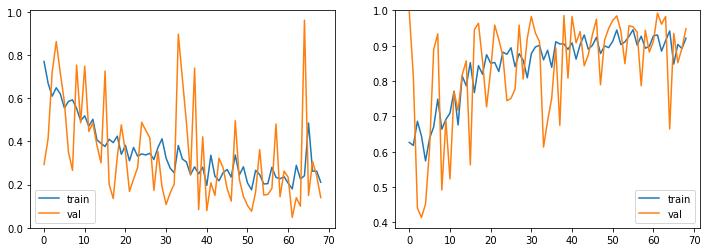

In [25]:
y = np.array([mrk.photo_reqs.frames_too_heavy.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frames_too_heavy')
list_model_files.append(model_file)

#### 20. Frame Covering Eyes  

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5943 - accuracy: 0.5800 - precision: 0.9267 - recall: 0.5309 - f1: 0.6532 - specificity: 0.7777 - negative_predictive_value: 0.2721 - matthews_correlation_coefficient: 0.2535 - val_loss: 0.5876 - val_accuracy: 0.6253 - val_precision: 0.9100 - val_recall: 0.6097 - val_f1: 0.7249 - val_specificity: 0.7077 - val_negative_predictive_value: 0.3011 - val_matthews_correlation_coefficient: 0.2576

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.25761, saving model to ../models/autoencoders_requirements/frame_covering_eyes_2020_03_20-01_52_30.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5834 - accuracy: 0.5685 - precision: 0.9383 - recall: 0.5003 - f1: 0.6396 - specificity: 0.8386 - negative_predictive_value: 0.2899 - matthews_correlation_coefficient: 0.2751 - val_loss: 0.5862 - val_accuracy: 0.6331 - val_p

4610/4610 [==============================] - 9s 2ms/step - loss: 0.5485 - accuracy: 0.6349 - precision: 0.9439 - recall: 0.5909 - f1: 0.7145 - specificity: 0.8294 - negative_predictive_value: 0.3314 - matthews_correlation_coefficient: 0.3363 - val_loss: 0.5701 - val_accuracy: 0.6149 - val_precision: 0.9578 - val_recall: 0.5576 - val_f1: 0.6987 - val_specificity: 0.8782 - val_negative_predictive_value: 0.3161 - val_matthews_correlation_coefficient: 0.3434

Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.35528
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5376 - accuracy: 0.6555 - precision: 0.9419 - recall: 0.6126 - f1: 0.7340 - specificity: 0.8333 - negative_predictive_value: 0.3445 - matthews_correlation_coefficient: 0.3549 - val_loss: 0.5986 - val_accuracy: 0.5846 - val_precision: 0.9729 - val_recall: 0.5117 - val_f1: 0.6628 - val_specificity: 0.9123 - val_negative_predictive_value: 0.3042 - val_matthews_correlation_coefficie


Epoch 00028: val_matthews_correlation_coefficient did not improve from 0.39351
Epoch 29/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5103 - accuracy: 0.6868 - precision: 0.9469 - recall: 0.6484 - f1: 0.7626 - specificity: 0.8429 - negative_predictive_value: 0.3709 - matthews_correlation_coefficient: 0.3918 - val_loss: 0.5147 - val_accuracy: 0.6999 - val_precision: 0.9455 - val_recall: 0.6760 - val_f1: 0.7831 - val_specificity: 0.8109 - val_negative_predictive_value: 0.3734 - val_matthews_correlation_coefficient: 0.3919

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39351
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5027 - accuracy: 0.6948 - precision: 0.9496 - recall: 0.6571 - f1: 0.7702 - specificity: 0.8464 - negative_predictive_value: 0.3776 - matthews_correlation_coefficient: 0.4030 - val_loss: 0.4800 - val_accuracy: 0.7086 - val_precision: 0.9190 - val_recall: 0.7094 - val_f1: 0.7969 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4705 - accuracy: 0.7067 - precision: 0.9530 - recall: 0.6606 - f1: 0.7758 - specificity: 0.8760 - negative_predictive_value: 0.3874 - matthews_correlation_coefficient: 0.4290 - val_loss: 0.5168 - val_accuracy: 0.6765 - val_precision: 0.9484 - val_recall: 0.6435 - val_f1: 0.7611 - val_specificity: 0.8294 - val_negative_predictive_value: 0.3565 - val_matthews_correlation_coefficient: 0.3775

Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.40890
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4820 - accuracy: 0.7069 - precision: 0.9514 - recall: 0.6714 - f1: 0.7800 - specificity: 0.8601 - negative_predictive_value: 0.3872 - matthews_correlation_coefficient: 0.4220 - val_loss: 0.5138 - val_accuracy: 0.6800 - val_precision: 0.9549 - val_recall: 0.6421 - val_f1: 0.7628 - val_specificity: 0.8558 - val_negative_predictive_value: 0.3615 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4741 - accuracy: 0.6983 - precision: 0.9623 - recall: 0.6550 - f1: 0.7733 - specificity: 0.8951 - negative_predictive_value: 0.3894 - matthews_correlation_coefficient: 0.4349 - val_loss: 0.5785 - val_accuracy: 0.6461 - val_precision: 0.9703 - val_recall: 0.5889 - val_f1: 0.7272 - val_specificity: 0.9055 - val_negative_predictive_value: 0.3424 - val_matthews_correlation_coefficient: 0.3910

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41877
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4584 - accuracy: 0.7087 - precision: 0.9653 - recall: 0.6622 - f1: 0.7803 - specificity: 0.8916 - negative_predictive_value: 0.3941 - matthews_correlation_coefficient: 0.4436 - val_loss: 0.5045 - val_accuracy: 0.7016 - val_precision: 0.9541 - val_recall: 0.6700 - val_f1: 0.7827 - val_specificity: 0.8468 - val_negative_predictive_value: 0.3771 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.41905
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4528 - accuracy: 0.7141 - precision: 0.9628 - recall: 0.6716 - f1: 0.7855 - specificity: 0.8816 - negative_predictive_value: 0.3983 - matthews_correlation_coefficient: 0.4444 - val_loss: 0.5481 - val_accuracy: 0.6817 - val_precision: 0.9607 - val_recall: 0.6402 - val_f1: 0.7638 - val_specificity: 0.8737 - val_negative_predictive_value: 0.3641 - val_matthews_correlation_coefficient: 0.4062

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.41905
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4440 - accuracy: 0.7169 - precision: 0.9681 - recall: 0.6697 - f1: 0.7866 - specificity: 0.8994 - negative_predictive_value: 0.3997 - matthews_correlation_coefficient: 0.4546 - val_loss: 0.6284 - val_accuracy: 0.6141 - val_precision: 0.9729 - val_recall: 0.5481 - val_f1: 0.6946 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.43821
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4602 - accuracy: 0.6980 - precision: 0.9637 - recall: 0.6543 - f1: 0.7731 - specificity: 0.8918 - negative_predictive_value: 0.3848 - matthews_correlation_coefficient: 0.4312 - val_loss: 0.4590 - val_accuracy: 0.7155 - val_precision: 0.9473 - val_recall: 0.6954 - val_f1: 0.7980 - val_specificity: 0.8103 - val_negative_predictive_value: 0.3838 - val_matthews_correlation_coefficient: 0.4069

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.43821
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4552 - accuracy: 0.7126 - precision: 0.9577 - recall: 0.6705 - f1: 0.7839 - specificity: 0.8800 - negative_predictive_value: 0.3919 - matthews_correlation_coefficient: 0.4336 - val_loss: 0.6285 - val_accuracy: 0.6193 - val_precision: 0.9673 - val_recall: 0.5570 - val_f1: 0.7006 - val_spe

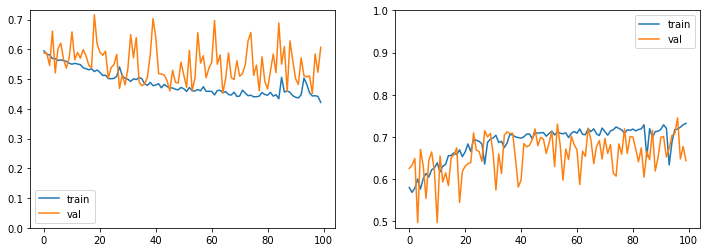

In [26]:
y = np.array([mrk.photo_reqs.frame_covering_eyes.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'frame_covering_eyes')
list_model_files.append(model_file)

#### 21. Hat/cap 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.5965 - accuracy: 0.5974 - precision: 0.9137 - recall: 0.5802 - f1: 0.6957 - specificity: 0.7159 - negative_predictive_value: 0.2268 - matthews_correlation_coefficient: 0.2080 - val_loss: 0.6558 - val_accuracy: 0.5412 - val_precision: 0.9745 - val_recall: 0.4949 - val_f1: 0.6464 - val_specificity: 0.8730 - val_negative_predictive_value: 0.2257 - val_matthews_correlation_coefficient: 0.2680

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.26803, saving model to ../models/autoencoders_requirements/hat_cap_2020_03_20-02_07_33.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5512 - accuracy: 0.6538 - precision: 0.9417 - recall: 0.6391 - f1: 0.7494 - specificity: 0.7445 - negative_predictive_value: 0.2676 - matthews_correlation_coefficient: 0.2797 - val_loss: 0.5387 - val_accuracy: 0.6713 - val_precision: 0.


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.36985
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4937 - accuracy: 0.7254 - precision: 0.9528 - recall: 0.7202 - f1: 0.8128 - specificity: 0.7831 - negative_predictive_value: 0.3355 - matthews_correlation_coefficient: 0.3740 - val_loss: 0.4051 - val_accuracy: 0.7884 - val_precision: 0.9177 - val_recall: 0.8355 - val_f1: 0.8723 - val_specificity: 0.5000 - val_negative_predictive_value: 0.3280 - val_matthews_correlation_coefficient: 0.2805

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.36985
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4811 - accuracy: 0.7312 - precision: 0.9500 - recall: 0.7245 - f1: 0.8154 - specificity: 0.7684 - negative_predictive_value: 0.3331 - matthews_correlation_coefficient: 0.3683 - val_loss: 0.5486 - val_accuracy: 0.6956 - val_precision: 0.9613 - val_recall: 0.6847 - val_f1: 0.7948 - val_spe

4610/4610 [==============================] - 9s 2ms/step - loss: 0.4826 - accuracy: 0.7158 - precision: 0.9473 - recall: 0.7000 - f1: 0.7956 - specificity: 0.7703 - negative_predictive_value: 0.3248 - matthews_correlation_coefficient: 0.3606 - val_loss: 0.4683 - val_accuracy: 0.7580 - val_precision: 0.9527 - val_recall: 0.7635 - val_f1: 0.8440 - val_specificity: 0.7212 - val_negative_predictive_value: 0.3409 - val_matthews_correlation_coefficient: 0.3722

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.39661
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4866 - accuracy: 0.7063 - precision: 0.9534 - recall: 0.6988 - f1: 0.7943 - specificity: 0.7759 - negative_predictive_value: 0.3151 - matthews_correlation_coefficient: 0.3503 - val_loss: 0.4493 - val_accuracy: 0.7684 - val_precision: 0.9613 - val_recall: 0.7693 - val_f1: 0.8515 - val_specificity: 0.7887 - val_negative_predictive_value: 0.3576 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.41395
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4230 - accuracy: 0.7796 - precision: 0.9598 - recall: 0.7754 - f1: 0.8532 - specificity: 0.7875 - negative_predictive_value: 0.3901 - matthews_correlation_coefficient: 0.4403 - val_loss: 0.4260 - val_accuracy: 0.7693 - val_precision: 0.9349 - val_recall: 0.7956 - val_f1: 0.8565 - val_specificity: 0.6012 - val_negative_predictive_value: 0.3205 - val_matthews_correlation_coefficient: 0.3130

Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.41395
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4204 - accuracy: 0.7727 - precision: 0.9610 - recall: 0.7681 - f1: 0.8501 - specificity: 0.7916 - negative_predictive_value: 0.3661 - matthews_correlation_coefficient: 0.4211 - val_loss: 0.3647 - val_accuracy: 0.7979 - val_precision: 0.9315 - val_recall: 0.8323 - val_f1: 0.8772 - val_spe


Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.41395
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3894 - accuracy: 0.7985 - precision: 0.9676 - recall: 0.7945 - f1: 0.8689 - specificity: 0.8343 - negative_predictive_value: 0.4087 - matthews_correlation_coefficient: 0.4770 - val_loss: 0.3854 - val_accuracy: 0.8014 - val_precision: 0.9553 - val_recall: 0.8137 - val_f1: 0.8764 - val_specificity: 0.6984 - val_negative_predictive_value: 0.3648 - val_matthews_correlation_coefficient: 0.4000

Epoch 00059: val_matthews_correlation_coefficient did not improve from 0.41395
Epoch 60/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3856 - accuracy: 0.7954 - precision: 0.9683 - recall: 0.7886 - f1: 0.8657 - specificity: 0.8355 - negative_predictive_value: 0.4099 - matthews_correlation_coefficient: 0.4779 - val_loss: 0.3263 - val_accuracy: 0.8378 - val_precision: 0.9214 - val_recall: 0.8927 - val_f1: 0.9055 - val_spe

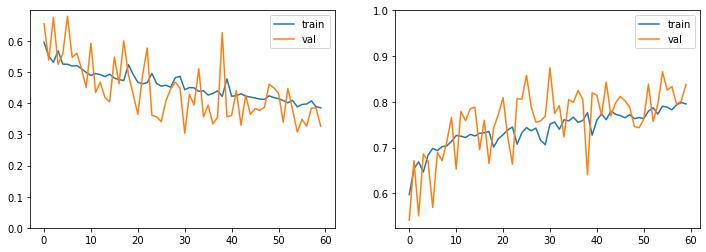

In [27]:
y = np.array([mrk.photo_reqs.hat_cap.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'hat_cap')
list_model_files.append(model_file)

#### *22. Veil Over Face*

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.4110 - accuracy: 0.7679 - precision: 0.9930 - recall: 0.7597 - f1: 0.8534 - specificity: 0.8003 - negative_predictive_value: 0.2149 - matthews_correlation_coefficient: 0.3415 - val_loss: 0.3422 - val_accuracy: 0.8560 - val_precision: 0.9623 - val_recall: 0.8337 - val_f1: 0.8923 - val_specificity: 0.7477 - val_negative_predictive_value: 0.2705 - val_matthews_correlation_coefficient: 0.3886

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.38865, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_20-02_16_35.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.3098 - accuracy: 0.8692 - precision: 0.9926 - recall: 0.8654 - f1: 0.9221 - specificity: 0.7458 - negative_predictive_value: 0.3197 - matthews_correlation_coefficient: 0.4318 - val_loss: 0.4093 - val_accuracy: 0.8335 - val_precisi

4610/4610 [==============================] - 9s 2ms/step - loss: 0.2471 - accuracy: 0.9124 - precision: 0.9925 - recall: 0.9143 - f1: 0.9508 - specificity: 0.7916 - negative_predictive_value: 0.4310 - matthews_correlation_coefficient: 0.5349 - val_loss: 0.3500 - val_accuracy: 0.8838 - val_precision: 0.9625 - val_recall: 0.8624 - val_f1: 0.9090 - val_specificity: 0.7477 - val_negative_predictive_value: 0.3098 - val_matthews_correlation_coefficient: 0.4273

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.52151
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.2365 - accuracy: 0.9102 - precision: 0.9925 - recall: 0.9083 - f1: 0.9471 - specificity: 0.7953 - negative_predictive_value: 0.4084 - matthews_correlation_coefficient: 0.5211 - val_loss: 0.2059 - val_accuracy: 0.9393 - val_precision: 0.9615 - val_recall: 0.9217 - val_f1: 0.9408 - val_specificity: 0.7252 - val_negative_predictive_value: 0.4807 - val_matthews_correlation_coefficie

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1967 - accuracy: 0.9317 - precision: 0.9936 - recall: 0.9341 - f1: 0.9622 - specificity: 0.7579 - negative_predictive_value: 0.4634 - matthews_correlation_coefficient: 0.5532 - val_loss: 0.2036 - val_accuracy: 0.9324 - val_precision: 0.9613 - val_recall: 0.9142 - val_f1: 0.9367 - val_specificity: 0.7252 - val_negative_predictive_value: 0.4499 - val_matthews_correlation_coefficient: 0.5330

Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.59807
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1956 - accuracy: 0.9232 - precision: 0.9902 - recall: 0.9250 - f1: 0.9546 - specificity: 0.8061 - negative_predictive_value: 0.4787 - matthews_correlation_coefficient: 0.5765 - val_loss: 0.3586 - val_accuracy: 0.8968 - val_precision: 0.9660 - val_recall: 0.8732 - val_f1: 0.9166 - val_specificity: 0.7725 - val_negative_predictive_value: 0.3459 - val_matthews_correlation_coefficie


Epoch 00043: val_matthews_correlation_coefficient did not improve from 0.63678
Epoch 44/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1957 - accuracy: 0.9384 - precision: 0.9940 - recall: 0.9407 - f1: 0.9657 - specificity: 0.7777 - negative_predictive_value: 0.5202 - matthews_correlation_coefficient: 0.5925 - val_loss: 0.1224 - val_accuracy: 0.9714 - val_precision: 0.9881 - val_recall: 0.9821 - val_f1: 0.9849 - val_specificity: 0.7198 - val_negative_predictive_value: 0.6644 - val_matthews_correlation_coefficient: 0.6677

Epoch 00044: val_matthews_correlation_coefficient improved from 0.63678 to 0.66774, saving model to ../models/autoencoders_requirements/veil_over_face_2020_03_20-02_16_35.h5
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1813 - accuracy: 0.9395 - precision: 0.9930 - recall: 0.9395 - f1: 0.9642 - specificity: 0.7968 - negative_predictive_value: 0.5361 - matthews_correlation_coefficient: 0.6144 - val_loss: 0.2919

4610/4610 [==============================] - 9s 2ms/step - loss: 0.1432 - accuracy: 0.9486 - precision: 0.9943 - recall: 0.9482 - f1: 0.9695 - specificity: 0.7800 - negative_predictive_value: 0.5451 - matthews_correlation_coefficient: 0.6225 - val_loss: 0.3569 - val_accuracy: 0.8899 - val_precision: 0.9648 - val_recall: 0.8668 - val_f1: 0.9125 - val_specificity: 0.7658 - val_negative_predictive_value: 0.3287 - val_matthews_correlation_coefficient: 0.4511

Epoch 00058: val_matthews_correlation_coefficient did not improve from 0.68591
Epoch 59/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1706 - accuracy: 0.9505 - precision: 0.9946 - recall: 0.9497 - f1: 0.9703 - specificity: 0.8391 - negative_predictive_value: 0.6289 - matthews_correlation_coefficient: 0.6858 - val_loss: 0.5120 - val_accuracy: 0.8283 - val_precision: 0.9661 - val_recall: 0.8008 - val_f1: 0.8751 - val_specificity: 0.7995 - val_negative_predictive_value: 0.2396 - val_matthews_correlation_coefficie


Epoch 00072: val_matthews_correlation_coefficient did not improve from 0.72134
Epoch 73/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1527 - accuracy: 0.9449 - precision: 0.9945 - recall: 0.9439 - f1: 0.9670 - specificity: 0.8000 - negative_predictive_value: 0.5535 - matthews_correlation_coefficient: 0.6288 - val_loss: 0.2450 - val_accuracy: 0.9063 - val_precision: 0.9671 - val_recall: 0.8821 - val_f1: 0.9221 - val_specificity: 0.7995 - val_negative_predictive_value: 0.3813 - val_matthews_correlation_coefficient: 0.5036

Epoch 00073: val_matthews_correlation_coefficient did not improve from 0.72134
Epoch 74/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1306 - accuracy: 0.9568 - precision: 0.9957 - recall: 0.9584 - f1: 0.9761 - specificity: 0.8369 - negative_predictive_value: 0.6037 - matthews_correlation_coefficient: 0.6775 - val_loss: 0.2845 - val_accuracy: 0.9063 - val_precision: 0.9670 - val_recall: 0.8822 - val_f1: 0.9222 - val_spe


Epoch 00087: val_matthews_correlation_coefficient did not improve from 0.72134
Epoch 88/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1243 - accuracy: 0.9553 - precision: 0.9964 - recall: 0.9562 - f1: 0.9753 - specificity: 0.8506 - negative_predictive_value: 0.5984 - matthews_correlation_coefficient: 0.6806 - val_loss: 0.2292 - val_accuracy: 0.9159 - val_precision: 0.9671 - val_recall: 0.8918 - val_f1: 0.9274 - val_specificity: 0.7995 - val_negative_predictive_value: 0.4065 - val_matthews_correlation_coefficient: 0.5223

Epoch 00088: val_matthews_correlation_coefficient did not improve from 0.72134
Epoch 89/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.1208 - accuracy: 0.9570 - precision: 0.9951 - recall: 0.9562 - f1: 0.9742 - specificity: 0.7791 - negative_predictive_value: 0.5956 - matthews_correlation_coefficient: 0.6522 - val_loss: 0.5908 - val_accuracy: 0.8101 - val_precision: 0.9674 - val_recall: 0.7809 - val_f1: 0.8628 - val_spe

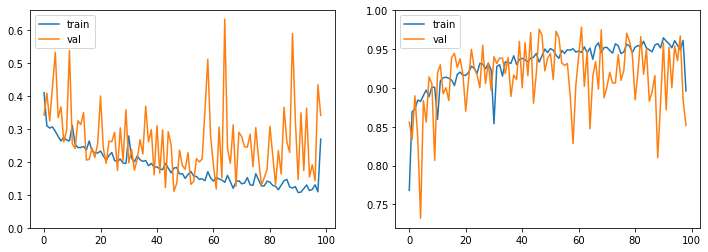

In [28]:
y = np.array([mrk.photo_reqs.veil_over_face.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'veil_over_face')
list_model_files.append(model_file)

#### 23. Mouth Open 

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\mlflow\utils\autologging_utils.py:60: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  all_param_names, _, _, all_default_values = inspect.getargspec(fn)  # pylint: disable=W1505


Train on 4610 samples, validate on 1153 samples
Epoch 1/100
4610/4610 [==============================] - 10s 2ms/step - loss: 0.6115 - accuracy: 0.6443 - precision: 0.8794 - recall: 0.6074 - f1: 0.7088 - specificity: 0.7523 - negative_predictive_value: 0.4013 - matthews_correlation_coefficient: 0.3203 - val_loss: 0.6147 - val_accuracy: 0.6210 - val_precision: 0.8624 - val_recall: 0.5366 - val_f1: 0.6568 - val_specificity: 0.8210 - val_negative_predictive_value: 0.4168 - val_matthews_correlation_coefficient: 0.3144

Epoch 00001: val_matthews_correlation_coefficient improved from -inf to 0.31437, saving model to ../models/autoencoders_requirements/mouth_open_2020_03_20-02_31_21.h5
Epoch 2/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5814 - accuracy: 0.6625 - precision: 0.8891 - recall: 0.6251 - f1: 0.7264 - specificity: 0.7878 - negative_predictive_value: 0.4406 - matthews_correlation_coefficient: 0.3667 - val_loss: 0.6235 - val_accuracy: 0.6236 - val_precision:


Epoch 00014: val_matthews_correlation_coefficient did not improve from 0.37750
Epoch 15/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5502 - accuracy: 0.6859 - precision: 0.8964 - recall: 0.6340 - f1: 0.7379 - specificity: 0.8169 - negative_predictive_value: 0.4556 - matthews_correlation_coefficient: 0.3981 - val_loss: 0.6414 - val_accuracy: 0.6253 - val_precision: 0.8717 - val_recall: 0.5371 - val_f1: 0.6597 - val_specificity: 0.8349 - val_negative_predictive_value: 0.4235 - val_matthews_correlation_coefficient: 0.3297

Epoch 00015: val_matthews_correlation_coefficient did not improve from 0.37750
Epoch 16/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5509 - accuracy: 0.6896 - precision: 0.8937 - recall: 0.6534 - f1: 0.7508 - specificity: 0.7819 - negative_predictive_value: 0.4518 - matthews_correlation_coefficient: 0.3875 - val_loss: 0.6060 - val_accuracy: 0.6496 - val_precision: 0.8723 - val_recall: 0.5738 - val_f1: 0.6879 - val_spe


Epoch 00029: val_matthews_correlation_coefficient did not improve from 0.40759
Epoch 30/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5327 - accuracy: 0.6970 - precision: 0.8975 - recall: 0.6606 - f1: 0.7566 - specificity: 0.7902 - negative_predictive_value: 0.4612 - matthews_correlation_coefficient: 0.4017 - val_loss: 0.5891 - val_accuracy: 0.6739 - val_precision: 0.8655 - val_recall: 0.6180 - val_f1: 0.7164 - val_specificity: 0.7849 - val_negative_predictive_value: 0.4563 - val_matthews_correlation_coefficient: 0.3586

Epoch 00030: val_matthews_correlation_coefficient did not improve from 0.40759
Epoch 31/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5337 - accuracy: 0.7017 - precision: 0.8970 - recall: 0.6708 - f1: 0.7623 - specificity: 0.7976 - negative_predictive_value: 0.4762 - matthews_correlation_coefficient: 0.4164 - val_loss: 0.5715 - val_accuracy: 0.7225 - val_precision: 0.8495 - val_recall: 0.7134 - val_f1: 0.7710 - val_spe


Epoch 00044: val_matthews_correlation_coefficient did not improve from 0.40759
Epoch 45/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5238 - accuracy: 0.7063 - precision: 0.9048 - recall: 0.6718 - f1: 0.7659 - specificity: 0.8002 - negative_predictive_value: 0.4712 - matthews_correlation_coefficient: 0.4191 - val_loss: 0.5619 - val_accuracy: 0.6774 - val_precision: 0.8697 - val_recall: 0.6185 - val_f1: 0.7192 - val_specificity: 0.7979 - val_negative_predictive_value: 0.4594 - val_matthews_correlation_coefficient: 0.3685

Epoch 00045: val_matthews_correlation_coefficient did not improve from 0.40759
Epoch 46/100
4610/4610 [==============================] - 9s 2ms/step - loss: 0.5170 - accuracy: 0.7117 - precision: 0.9047 - recall: 0.6780 - f1: 0.7689 - specificity: 0.8019 - negative_predictive_value: 0.4754 - matthews_correlation_coefficient: 0.4273 - val_loss: 0.6666 - val_accuracy: 0.6435 - val_precision: 0.8793 - val_recall: 0.5615 - val_f1: 0.6801 - val_spe

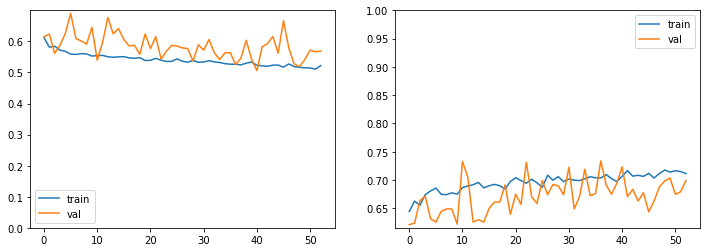

In [29]:
y = np.array([mrk.photo_reqs.mouth_open.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'mouth_open')
list_model_files.append(model_file)

#### *24. Presence of Other Faces or Toys too Close to Face*

In [30]:
y = np.array([mrk.photo_reqs.presence_of_other_faces_or_toys.value for mrk in mrks])

model_file = train_requirement_branch(encoder, x, y, 'presence_of_other_faces_or_toys')
list_model_files.append(model_file)

the requirement presence_of_other_faces_or_toys has only one label.


# Models Merge

In [31]:
def add_requirement_branch_to_base_model(base_model_last_layer, req_model):
    req_layers = [layer for layer in req_model.layers if isinstance(layer, Dense)]

    outputs = base_model_last_layer
    for layer in req_layers:
        outputs = req_model.get_layer(layer.name)(outputs)

    return outputs

In [32]:
file_models = np.array([file for file in list_model_files if file is not None])

print(file_models)

['../models/autoencoders_requirements/blurred_2020_03_19-22_35_06.h5'
 '../models/autoencoders_requirements/looking_away_2020_03_19-22_47_08.h5'
 '../models/autoencoders_requirements/ink_marked_creased_2020_03_19-22_57_13.h5'
 '../models/autoencoders_requirements/unnatural_skin_tone_2020_03_19-23_03_30.h5'
 '../models/autoencoders_requirements/too_dark_light_2020_03_19-23_18_15.h5'
 '../models/autoencoders_requirements/washed_out_2020_03_19-23_26_14.h5'
 '../models/autoencoders_requirements/pixelation_2020_03_19-23_31_40.h5'
 '../models/autoencoders_requirements/hair_across_eyes_2020_03_19-23_37_23.h5'
 '../models/autoencoders_requirements/eyes_closed_2020_03_19-23_48_44.h5'
 '../models/autoencoders_requirements/varied_background_2020_03_20-00_03_35.h5'
 '../models/autoencoders_requirements/roll_pitch_yaw_2020_03_20-00_18_24.h5'
 '../models/autoencoders_requirements/flash_reflection_on_skin_2020_03_20-00_33_12.h5'
 '../models/autoencoders_requirements/red_eyes_2020_03_20-00_48_04.h5'
 

In [33]:
autoencoder = load_model(FILE_BASE_MODEL)

embeddings = GlobalAvgPool2D(name='embeddings')(autoencoder.get_layer(name='encoded').output)

C:\Users\arnal\Miniconda3\envs\dl-gpu\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [34]:
custom_objects = {
    'recall': recall,
    'precision': precision,
    'f1': f1,
    'specificity': specificity,
    'negative_predictive_value': npv,
    'matthews_correlation_coefficient': mcc
}

list_models = [load_model(file, custom_objects=custom_objects) for file in file_models]
list_outputs = [add_requirement_branch_to_base_model(embeddings, model) for model in list_models]

In [35]:
merged_model = Model(inputs=autoencoder.inputs, outputs=list_outputs)
merged_model.summary()

merged_model.save(f'{FOLDER_MODELS}merged_model_{USER_IDS}.h5')

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 16) 448         input[0][0]                      
__________________________________________________________________________________________________
bn_1 (BatchNormalization)       (None, 224, 224, 16) 64          conv_1[0][0]                     
__________________________________________________________________________________________________
relu_1 (Activation)             (None, 224, 224, 16) 0           bn_1[0][0]                       
___________________________________________________________________________________________

In [36]:
import cv2
from glob import glob

list_files = glob('../data/pybossa/images/*')
random_file = np.random.choice(list_files)
print(random_file)

im = load.images_from_list_files([random_file], output_size=IMAGE_SIZE, interpolation=cv2.INTER_AREA)
im /= 255

y_pred = merged_model.predict(im)
list_predictions = [model.predict(im) for model in list_models]
assert(np.all([np.allclose(pred1, pred2) for pred1, pred2 in zip(y_pred, list_predictions)]))

y_pred

../data/pybossa/images\AR_FDB_m-006-16.png
1 of 1


[array([[0.9997534]], dtype=float32),
 array([[0.5283868]], dtype=float32),
 array([[0.40074167]], dtype=float32),
 array([[0.77513045]], dtype=float32),
 array([[0.98231214]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.83024865]], dtype=float32),
 array([[0.9145437]], dtype=float32),
 array([[0.6043246]], dtype=float32),
 array([[0.46370196]], dtype=float32),
 array([[0.7582017]], dtype=float32),
 array([[0.4108757]], dtype=float32),
 array([[0.4199942]], dtype=float32),
 array([[0.999814]], dtype=float32),
 array([[0.9582312]], dtype=float32),
 array([[0.8240334]], dtype=float32),
 array([[0.19334273]], dtype=float32),
 array([[0.9754919]], dtype=float32),
 array([[0.85421216]], dtype=float32),
 array([[0.99835545]], dtype=float32),
 array([[0.99534804]], dtype=float32),
 array([[0.43496004]], dtype=float32)]